**Progetto Machine Learning**

Partecipanti
- Fiorentini Nicolò  933157
- Roncoroni Samuele 935111

In questo progetto si analizza l'impatto della contaminazione dei dati sulle prestazioni dei modelli di machine learning. Dopo aver selezionato un dataset adeguato, si esegue un’analisi esplorativa e si scelgono due modelli (per classificazione o regressione). I modelli vengono inizialmente addestrati su dati puliti per stabilire una baseline. Successivamente, si introduce contaminazione progressiva nei dati tramite tecniche controllate. Infine, si valutano le prestazioni dei modelli per identificare le feature più influenti e gli effetti del rumore.

In questa situazione, non si sta cercando di fare un modello perfetto, ma di capire quanto un modello è robusto a diverse quantità di rumore introdotte artificialmente. È quindi un esperimento comparativo e controllato.

#Dataset

In [481]:
#Diamo accesso al nostro google drive che conterrà il dataset che utilizzeremo
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sn
from sklearn.tree import DecisionTreeClassifier, plot_tree
import requests
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)

url = "https://raw.githubusercontent.com/NIKFIORE/Progetto-Machine-Learning/refs/heads/main/Dataset/Cancer_Data.csv"
# Carica il dataset direttamente da GitHub
df = pd.read_csv(url)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

# Esplorazione dei Dati (EDA)

Analizza la distribuzione delle feature, la presenza di valori mancanti, correlazioni e altre statistiche descrittive utili.

In [482]:
print(f"Numero di istanze nel dataset: {df.shape[0]}")

Numero di istanze nel dataset: 569


 📈 Ingrandimento del dataset

L’ingrandimento del dataset non è stato effettuato, in quanto le 569 istanze originali risultano sufficienti per lo scopo dello studio, che è analizzare l’effetto progressivo del rumore sulle performance del modello. Aumentare artificialmente le istanze avrebbe introdotto variabilità non controllata, con il rischio di mascherare gli effetti del rumore stesso. Si è preferito quindi mantenere il dataset originale per garantire coerenza e semplicità nell’analisi.


In [483]:
df.drop(columns=["id"], inplace= True)
df.drop(columns=["Unnamed: 32"], inplace= True)
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst             float64
fractal_dimension_worst    float64
dtype: object

In [484]:
#controllo il numero di valori duplicati
df.duplicated().sum().item()

0

In [485]:
# Verifico se ci sono valori mancanti
missing_value = df.isnull().values.any()

# Definisco x prima di usarlo
if not missing_value:
    x = "non"
else:
    x = ""

print(f"Questo dataset {x} ha valori mancanti")

Questo dataset non ha valori mancanti


In [486]:
# Controlla i valori unici nella colonna 'diagnosis'
print(df['diagnosis'].unique())

['M' 'B']


In [487]:
# Mappatura della colonna 'diagnosis'
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [488]:
# Rimuove la variabile target
df_features_only = df.drop(columns=['diagnosis'])

# Ottieni automaticamente tutte le features numeriche (float)
numeric_features = df_features_only.select_dtypes(include=['float64', 'float32']).columns.tolist()
target = "diagnosis"

print(f"Features numeriche trovate: {numeric_features}")
print(f"Numero di features: {len(numeric_features)}")

Features numeriche trovate: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Numero di features: 30


Rimozione della variabile target, per la matrice di corelazione, perchè in base alla codifica, della diagnosis, avrebbe influenzato il risultato

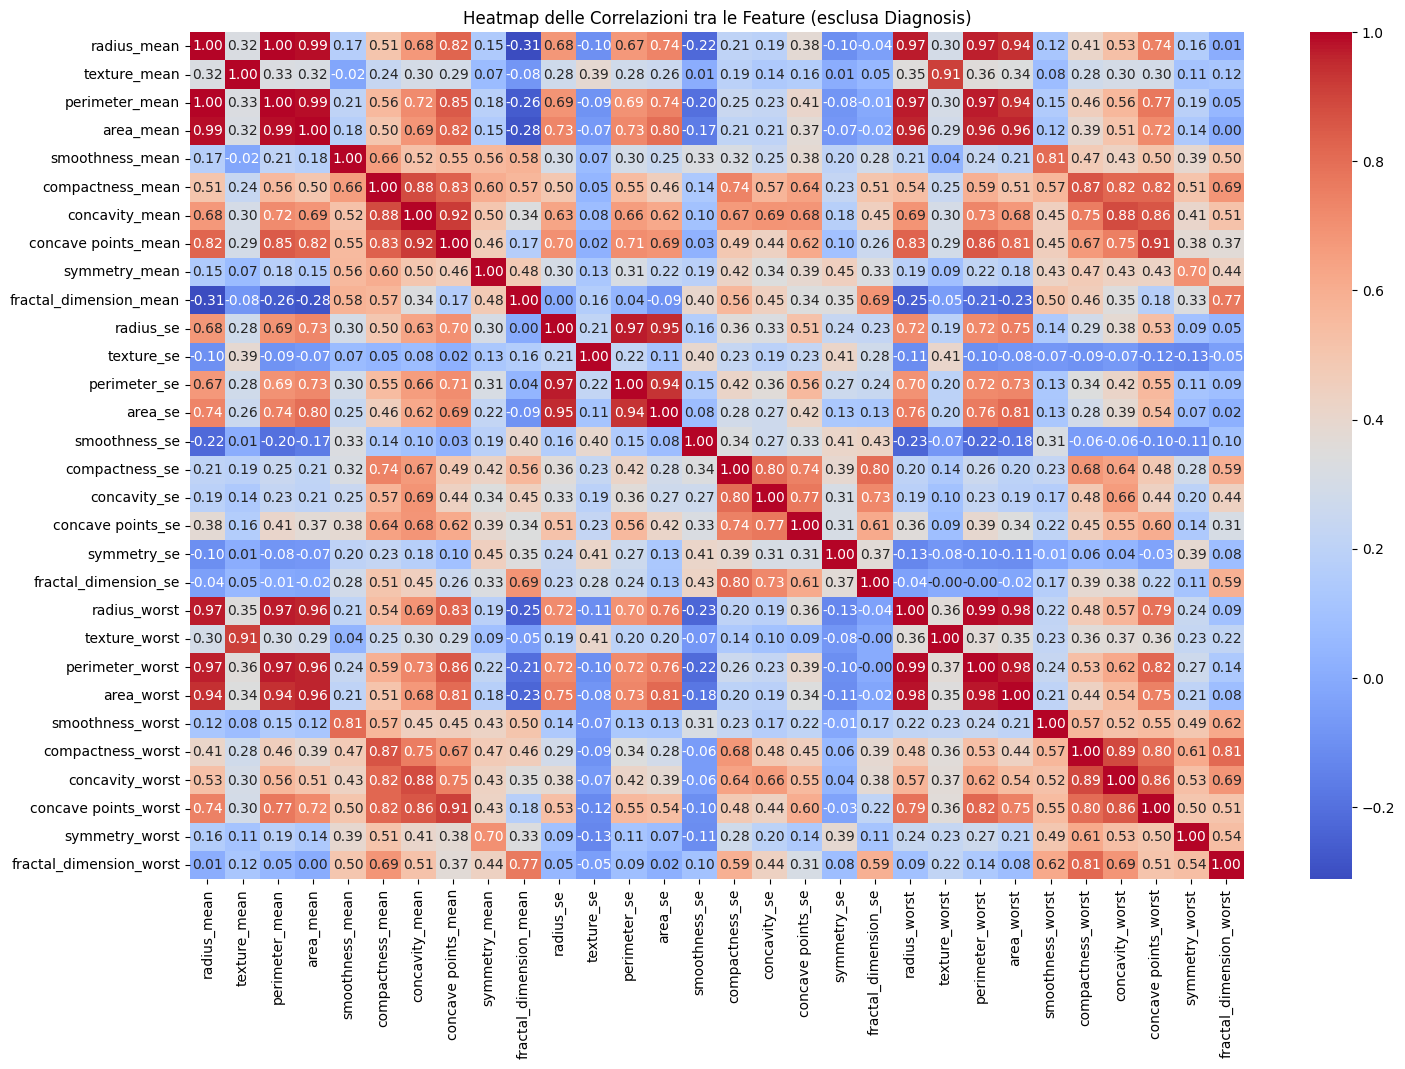

In [489]:
# Calcola la matrice di correlazione
correlation = df_features_only.corr()

# Crea la heatmap completa
plt.figure(figsize=(17, 11))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap delle Correlazioni tra le Feature (esclusa Diagnosis)')
plt.show()

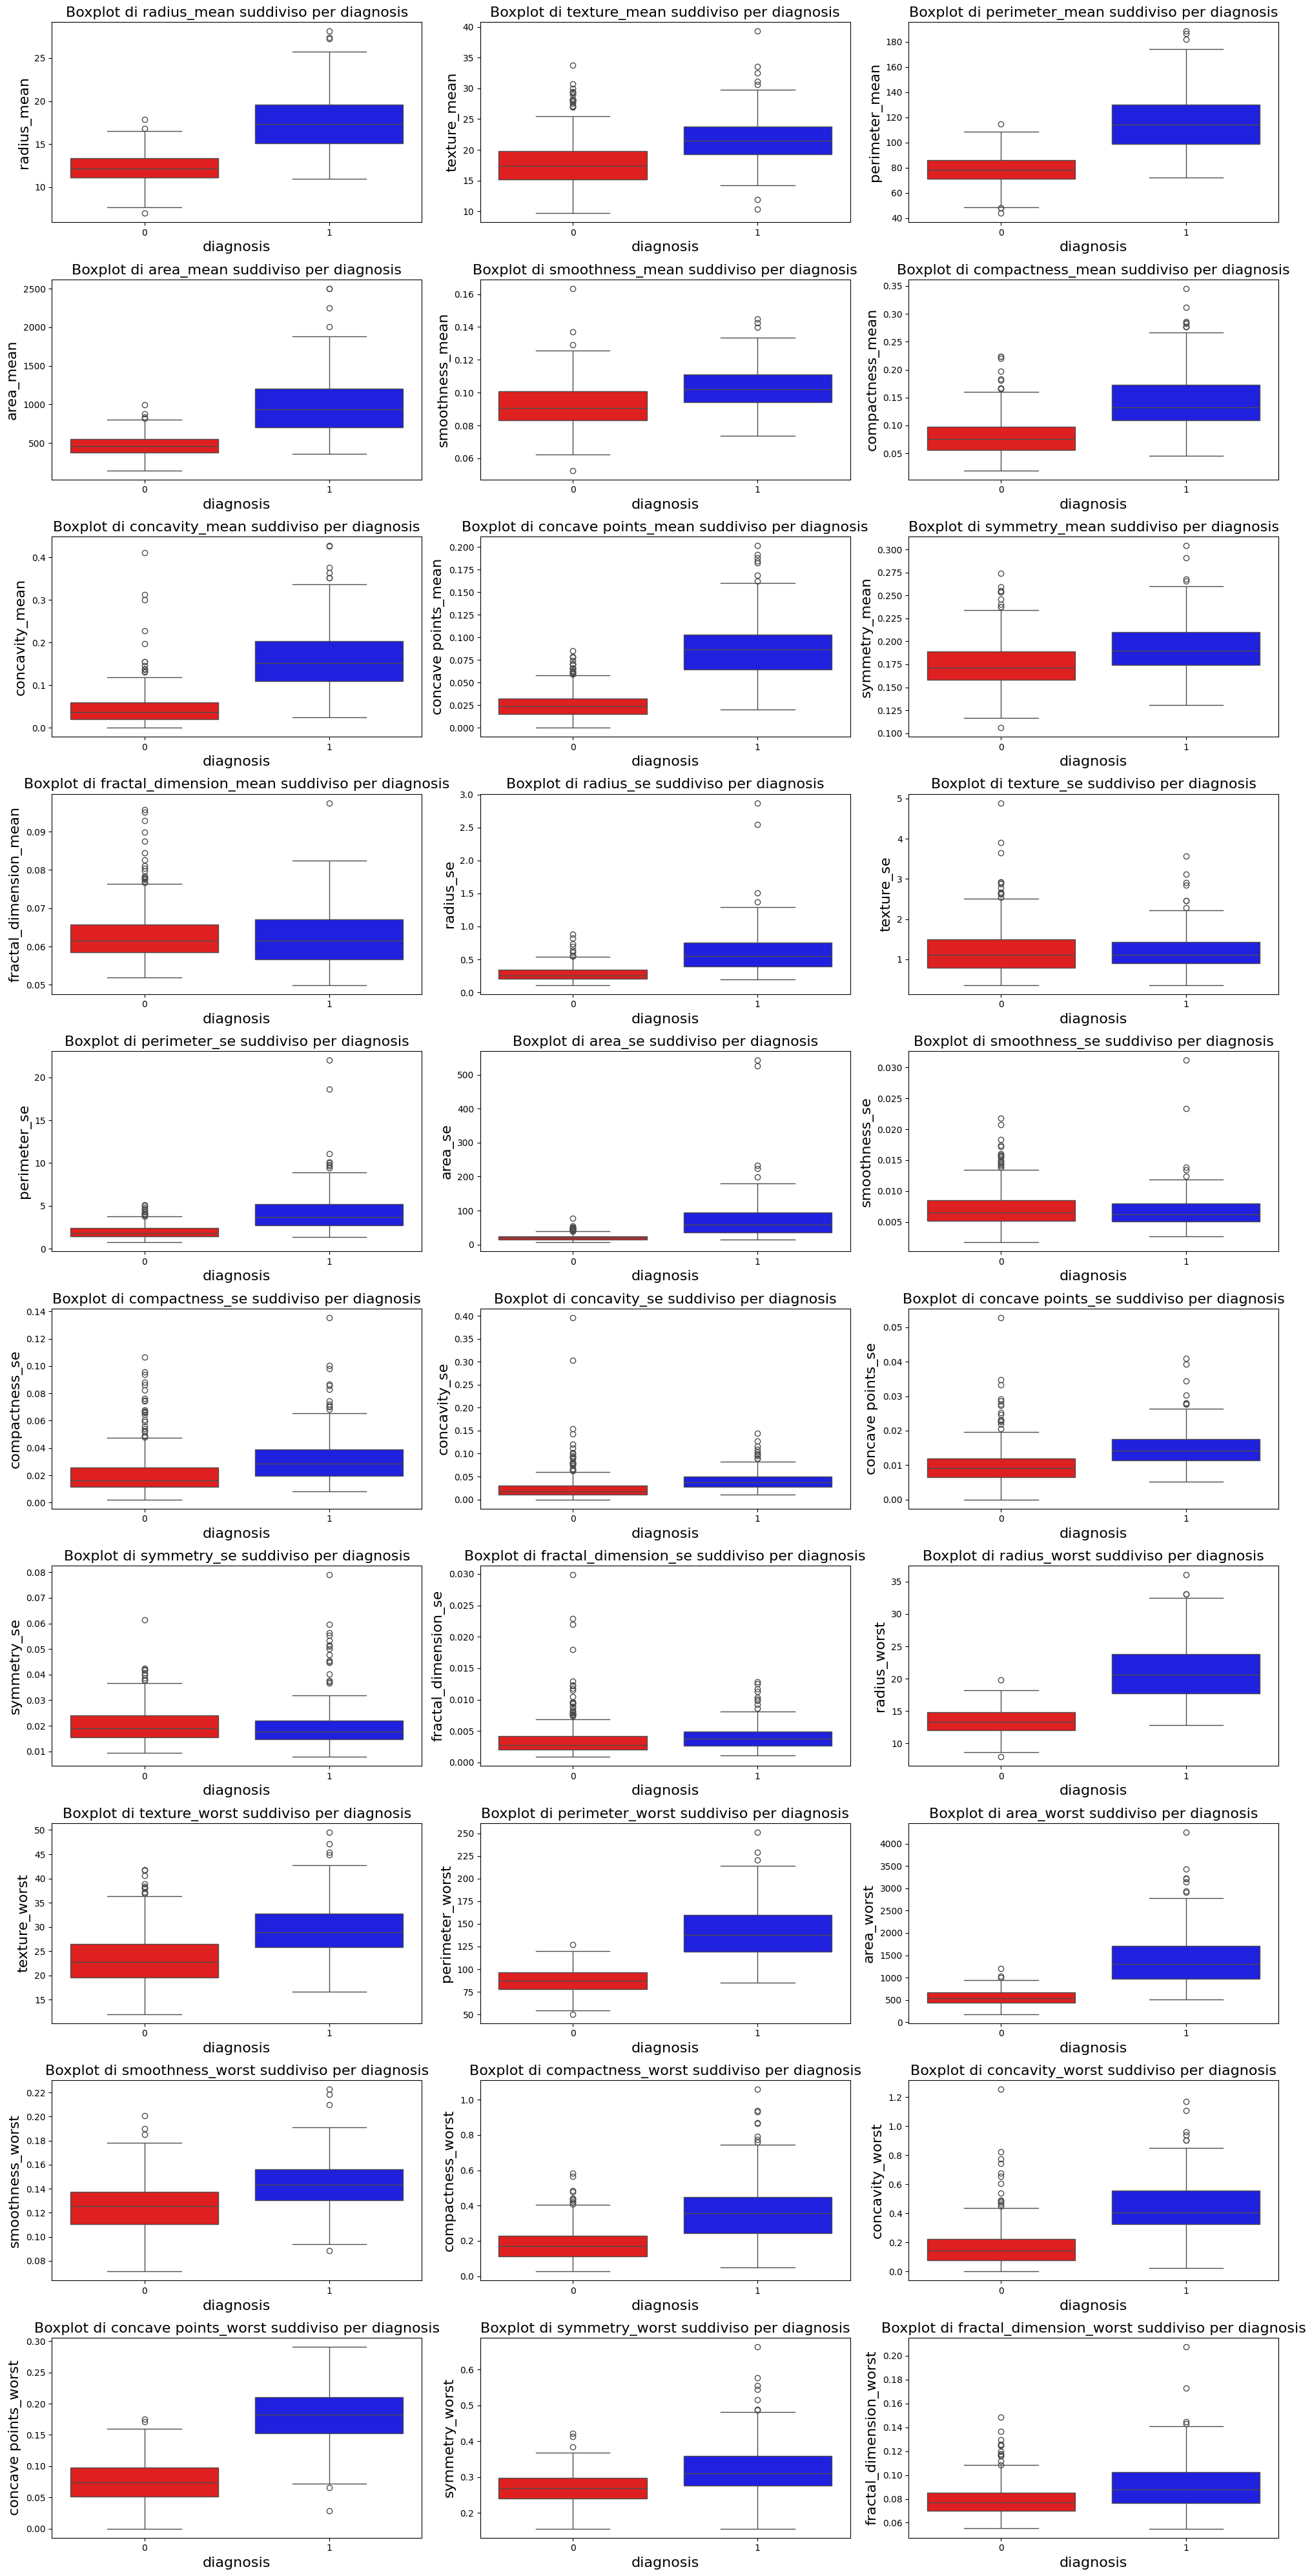

In [490]:
# Calcola il numero di righe e colonne per la griglia
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Calcolo del numero di righe necessarie

# BOXPLOT
plt.figure(figsize=(20, 4 * n_rows))  # Altezza dinamica basata sul numero di righe
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=target, y=feature, data=df, hue=target, palette=['red', 'blue'], legend=False)
    plt.title(f'Boxplot di {feature} suddiviso per {target}', fontsize=16)
    plt.xlabel(target, fontsize=16)
    plt.ylabel(feature, fontsize=16)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.axis('off')

plt.tight_layout()
plt.savefig("Boxplot_Features_Numeriche.pdf")
plt.show()

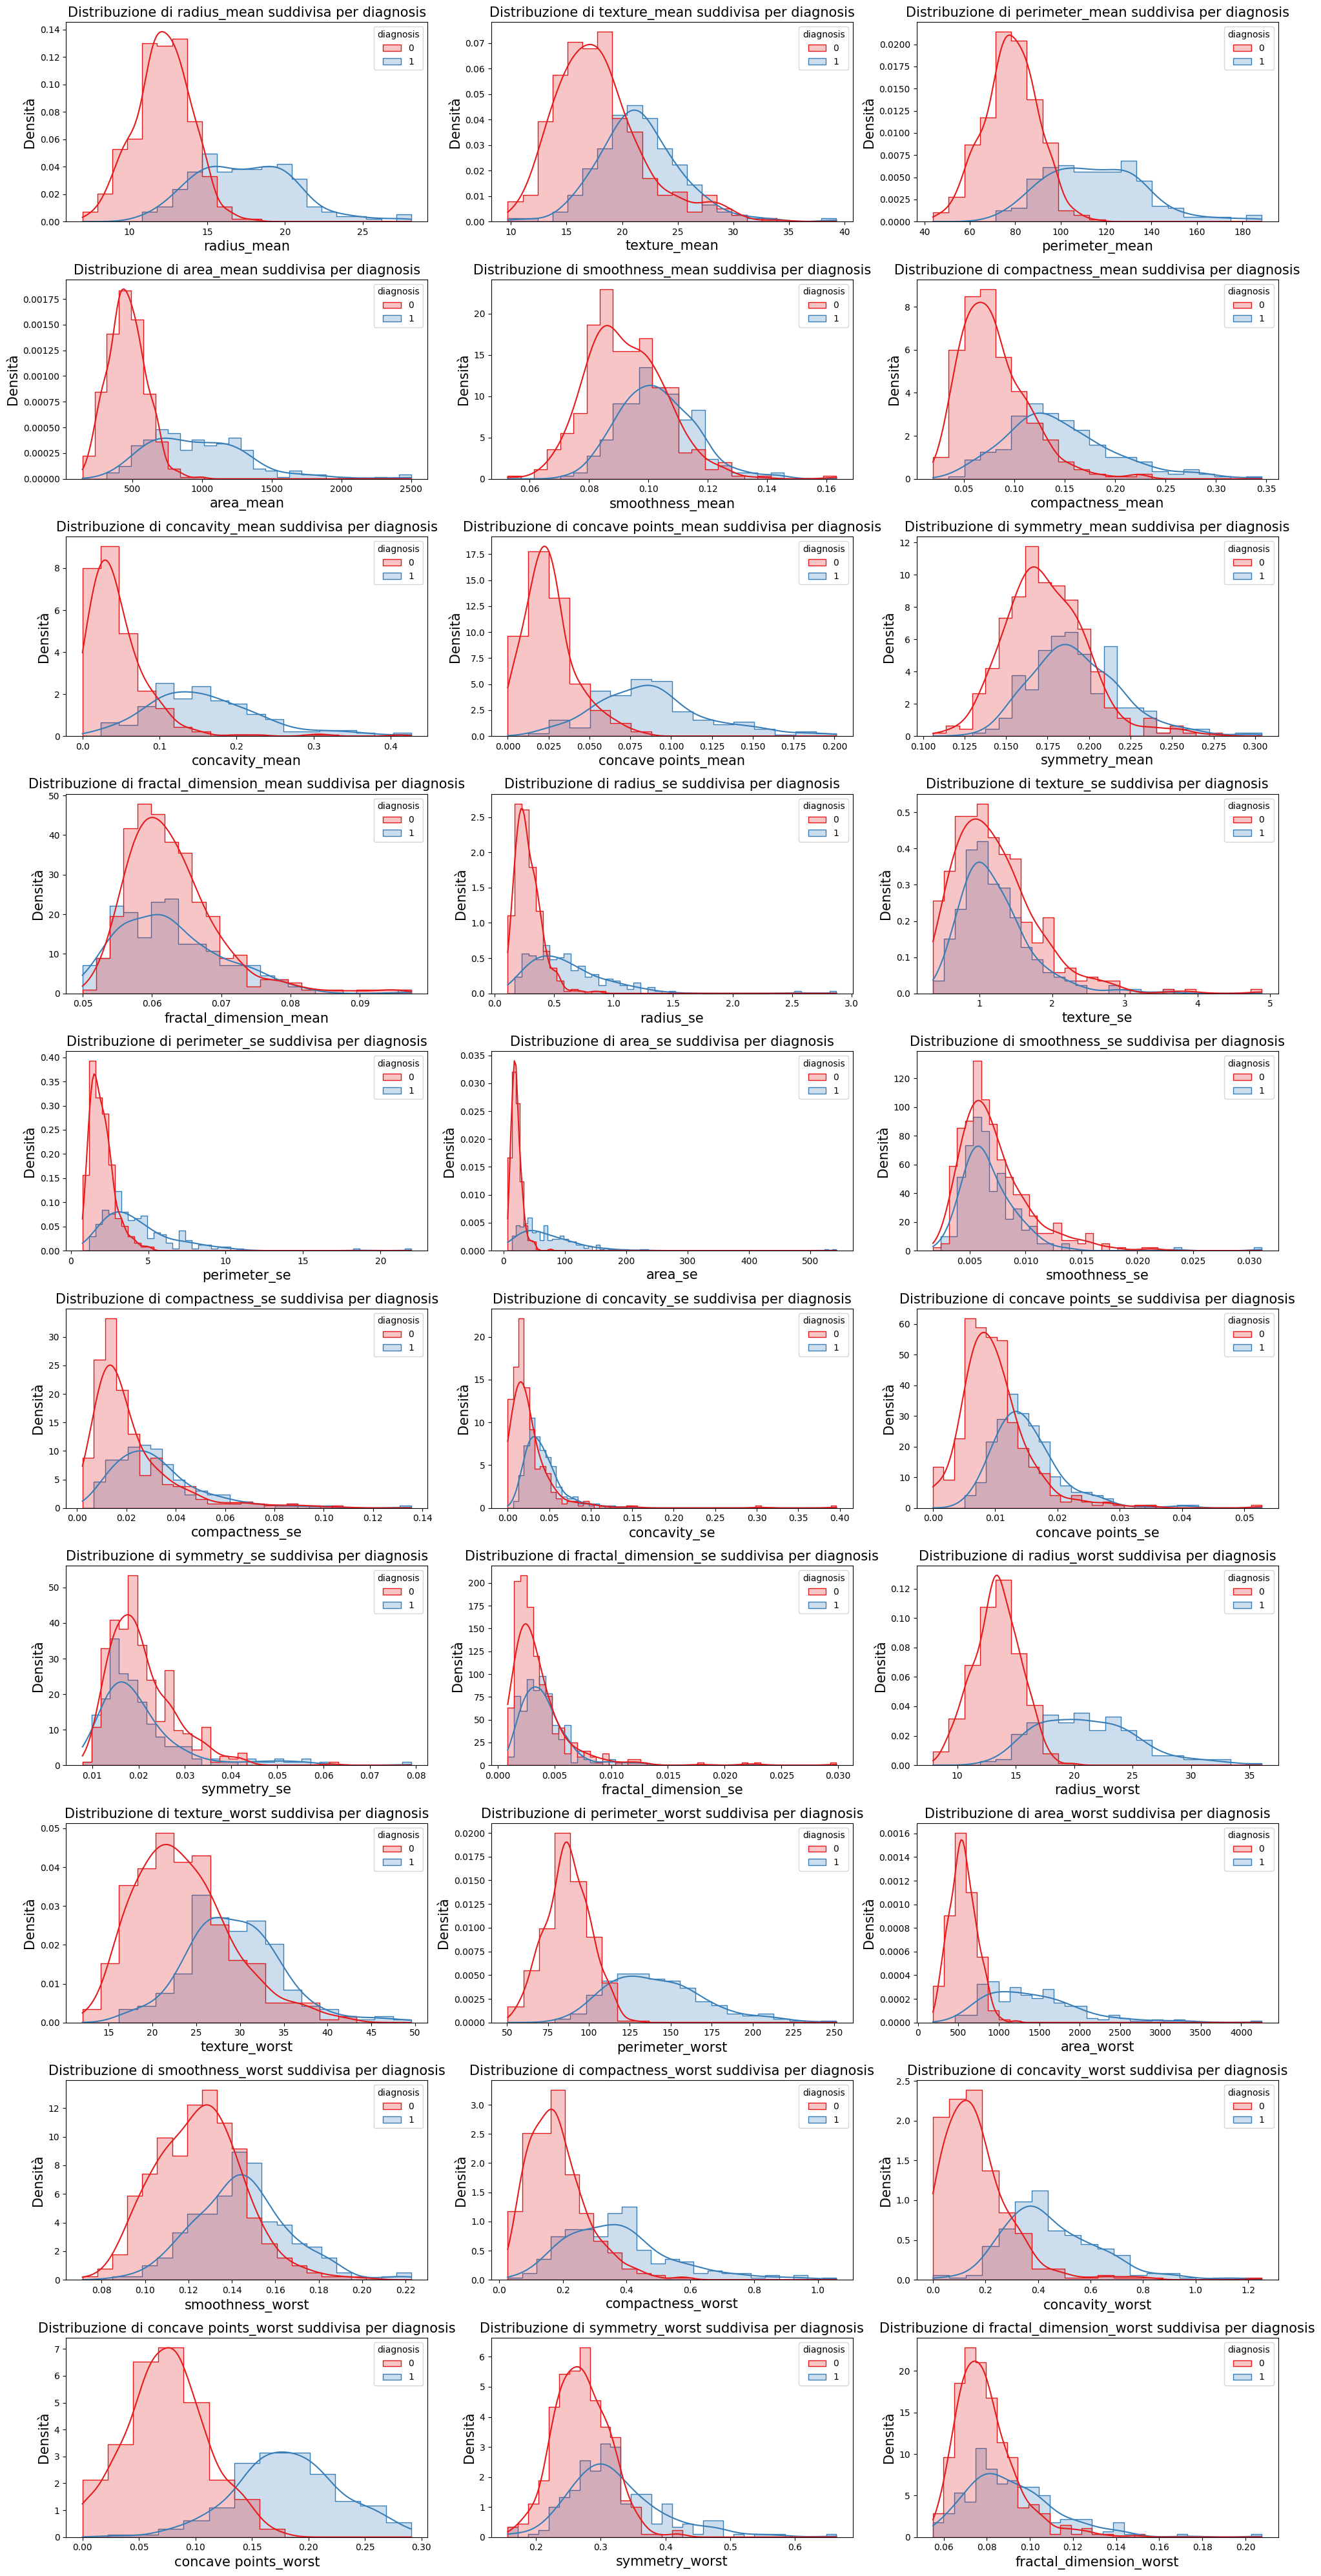

In [491]:
# GRAFICI DI DISTRIBUZIONE
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharey=False)

# Gestisci il caso di una sola riga
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df, x=feature, hue=target, kde=True, element="step",
                palette="Set1", stat="density", ax=axes[i])
    axes[i].set_title(f"Distribuzione di {feature} suddivisa per {target}", fontsize=15)
    axes[i].set_xlabel(feature, fontsize=15)
    axes[i].set_ylabel("Densità", fontsize=15)

# Rimuovi subplot vuoti se presenti
for i in range(n_features, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("Distribuzione_Features_Numeriche.pdf")
plt.show()

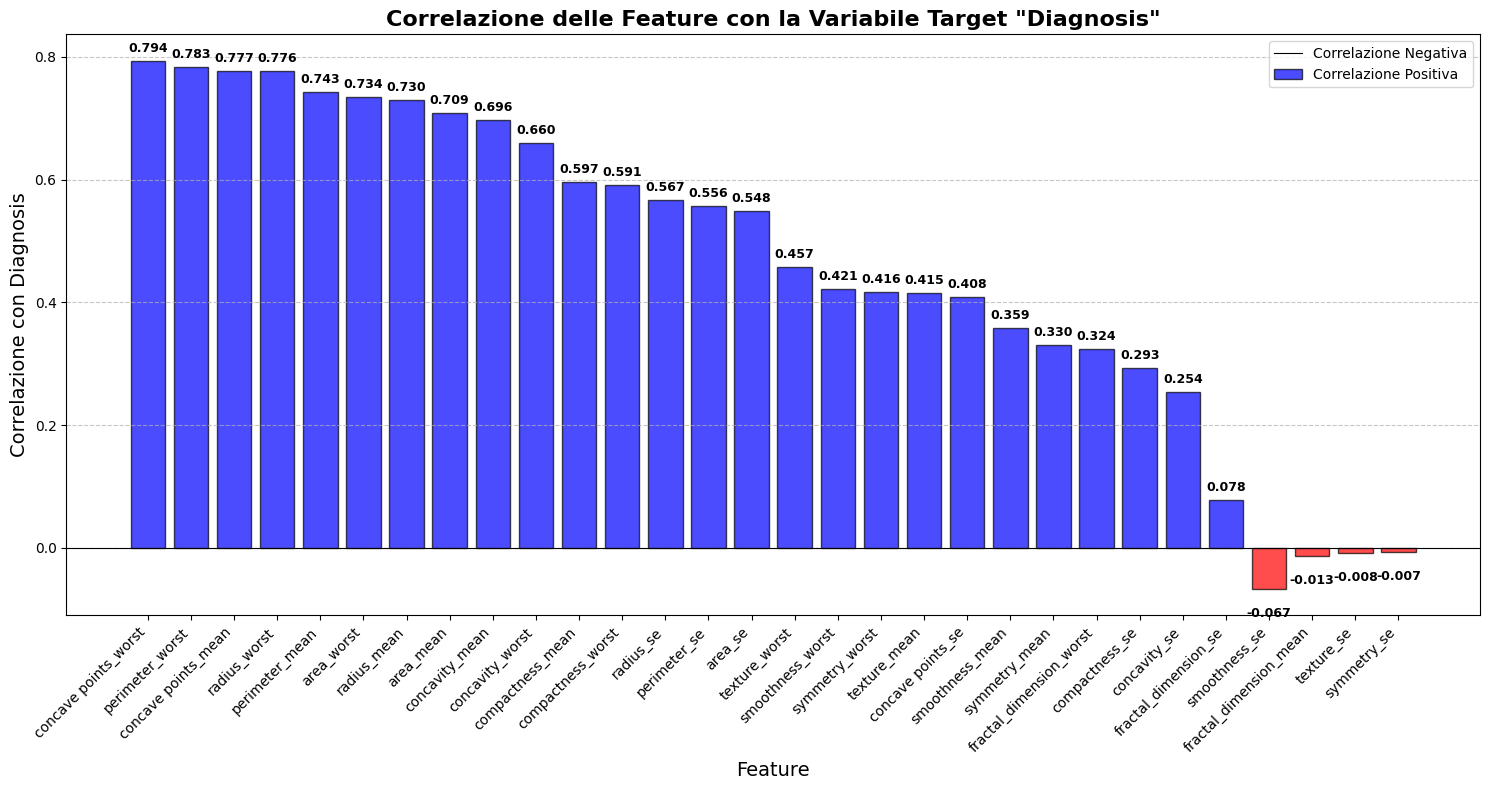


Top 10 Feature più correlate con 'Diagnosis':
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis, dtype: float64


In [492]:
# Calcola la correlazione tra tutte le feature e il target 'diagnosis'
correlations_with_target = df[numeric_features + ['diagnosis']].corr()['diagnosis'].drop('diagnosis')

# Ordina le correlazioni in valore assoluto (per vedere sia correlazioni positive che negative)
correlations_sorted = correlations_with_target.reindex(correlations_with_target.abs().sort_values(ascending=False).index)

# Crea il grafico a barre
plt.figure(figsize=(15, 8))
colors = ['red' if x < 0 else 'blue' for x in correlations_sorted.values]
bars = plt.bar(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')

# Personalizza il grafico
plt.title('Correlazione delle Feature con la Variabile Target "Diagnosis"', fontsize=16, fontweight='bold')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Correlazione con Diagnosis', fontsize=14)
plt.xticks(range(len(correlations_sorted)), correlations_sorted.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiungi una linea orizzontale a y=0
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Aggiungi i valori sopra ogni barra
for i, (bar, value) in enumerate(zip(bars, correlations_sorted.values)):
   plt.text(bar.get_x() + bar.get_width()/2, value + (0.01 if value > 0 else -0.03),
            f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top', fontweight='bold', fontsize=9)

# Aggiungi una leggenda
plt.legend(['Correlazione Negativa', 'Correlazione Positiva'], loc='upper right')

plt.tight_layout()
plt.show()

# Stampa le top 10 correlazioni più forti (in valore assoluto)
print("\nTop 10 Feature più correlate con 'Diagnosis':")
print(correlations_sorted.head(10))

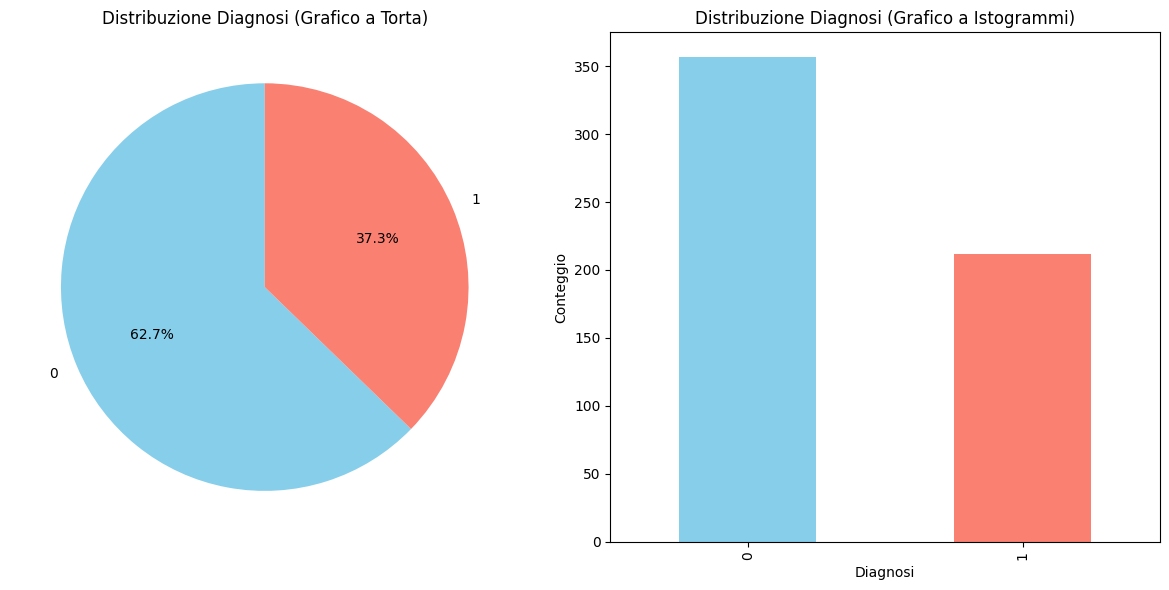

CONFRONTO DISTRIBUZIONE CLASSI:
diagnosis
0    357
1    212
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 62.7%
Percentuale classe 1 (Maligno): 37.3%


In [493]:
# Plot a torta
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico a torta
plt.subplot(1, 2, 1)
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Torta)')
plt.ylabel('')

# Subplot 2: Grafico a istogrammi
plt.subplot(1, 2, 2)
df['diagnosis'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi (Grafico a Istogrammi)')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

# Mostra il grafico
plt.tight_layout()
plt.show()

print("CONFRONTO DISTRIBUZIONE CLASSI:")
print(df['diagnosis'].value_counts())
print(f"Percentuale classe 0 (Benigno): {df['diagnosis'].value_counts()[0]/len(df)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {df['diagnosis'].value_counts()[1]/len(df)*100:.1f}%")

⚖️ Bilanciamento del target

Il dataset originale presenta una leggera asimmetria tra classi: circa il 62,7% delle istanze sono benigne, mentre il 37,3% sono maligne. Questo sbilanciamento può influenzare negativamente l’apprendimento del modello, portandolo a privilegiare la classe maggioritaria e falsando metriche come l'accuracy. In uno studio volto a valutare la sensibilità del modello al rumore, è fondamentale che le condizioni iniziali siano equilibrate, per evitare che il degrado delle performance sia attribuibile allo sbilanciamento piuttosto che al rumore stesso. Per questo, il bilanciamento del target è stato considerato un passo essenziale, realizzato tramite tecniche di oversampling come SMOTE, al fine di garantire una valutazione imparziale e significativa.


Come bilanciare il target (M/B)?
Tre strategie principali:

- Undersampling: riduci i benigni (B) → perdi informazione.

- Oversampling: duplichi i maligni (M) → rischio overfitting.

- SMOTE (Synthetic Minority Over-sampling Technique): genera nuovi esempi maligni interpolando tra quelli esistenti → consigliato.

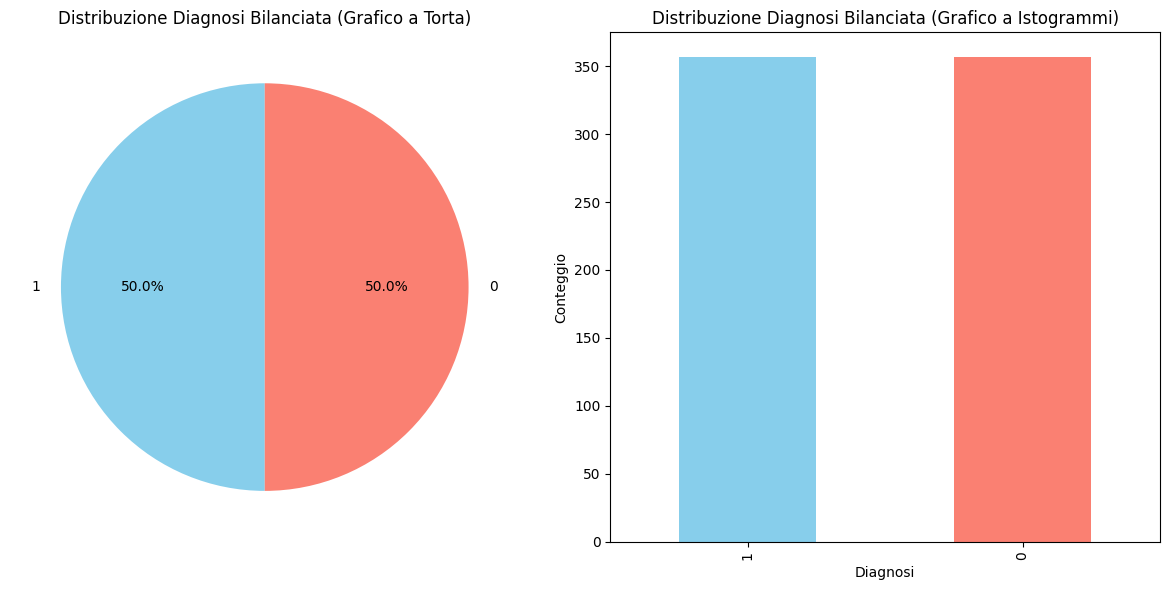

CONFRONTO DISTRIBUZIONE CLASSI:

Dopo il bilanciamento:
diagnosis
1    357
0    357
Name: count, dtype: int64
Percentuale classe 0 (Benigno): 50.0%
Percentuale classe 1 (Maligno): 50.0%


In [494]:
# Bilanciamento del dataset usando SMOTE
from imblearn.over_sampling import SMOTE

# Separa features e target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Applica SMOTE per bilanciare il dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Crea il nuovo dataset bilanciato
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['diagnosis'] = y_balanced

# Visualizza la distribuzione dopo il bilanciamento
plt.figure(figsize=(12, 6))

# Subplot 1: Grafico a torta dopo bilanciamento
plt.subplot(1, 2, 1)
df_balanced['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi Bilanciata (Grafico a Torta)')
plt.ylabel('')

# Subplot 2: Grafico a istogrammi dopo bilanciamento
plt.subplot(1, 2, 2)
df_balanced['diagnosis'].value_counts().plot.bar(color=['skyblue', 'salmon'])
plt.title('Distribuzione Diagnosi Bilanciata (Grafico a Istogrammi)')
plt.xlabel('Diagnosi')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()

# Confronto prima e dopo
print("CONFRONTO DISTRIBUZIONE CLASSI:")
print("\nDopo il bilanciamento:")
print(df_balanced['diagnosis'].value_counts())
print(f"Percentuale classe 0 (Benigno): {df_balanced['diagnosis'].value_counts()[0]/len(df_balanced)*100:.1f}%")
print(f"Percentuale classe 1 (Maligno): {df_balanced['diagnosis'].value_counts()[1]/len(df_balanced)*100:.1f}%")

# Aggiorna il dataframe principale per il resto dell'analisi
df = df_balanced.copy()

In [495]:
print(f"Numero di istanze nel dataset: {df.shape[0]}")

Numero di istanze nel dataset: 714


# Applicazione dei modelli

In [496]:
# Droppiamo la variabile target
X = df_balanced.drop('diagnosis', axis=1)
y = df_balanced['diagnosis']

# dividi il dataset in training e validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Funzione che crea e addestra i modelli

QUESTIONE DEI GRAFICI DA RISOLVERE NELLA FUNZIONE DELLA CREAZIONE DEI MODELLI

In [497]:
# Neural Network model
def create_neural_network_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),  # Use Input layer instead of specifying input_shape in Dense
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    #model.summary()
    return model

# SVM Model
def create_and_train_svm_model(X_train, y_train, kernel='rbf', C=1):
    model = SVC(kernel=kernel, C=C, probability=True)
    model.fit(X_train, y_train)
    return model

# Decision Tree Model
def create_and_train_decision_tree(X_train, y_train, random_state=42, **kwargs):
    model = DecisionTreeClassifier(random_state=random_state, **kwargs)
    model.fit(X_train, y_train)

    # Visualizza l'albero decisionale
    #fig, ax = plt.subplots(figsize=(150, 100))
    #plot_tree(model, filled=True, ax=ax)
    #plt.plot()
    return model

Funzione per misurare e visionare le performance dei modelli

In [498]:
def evaluate_model_performance(y_true, y_pred, model_name):
    """
    Comprehensive model performance evaluation

    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model

    Returns:
    - Dictionary of performance metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print detailed classification report
    print(f"\n{model_name} - Detailed Classification Report:")
    print(classification_report(y_true, y_pred))

    # Print formatted metrics summary
    print(f"\n{model_name} - Performance Metrics Summary:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Create compact confusion matrix plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                cbar_kws={'shrink': 0.8})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=10, pad=10)
    plt.ylabel('True Label', fontsize=9)
    plt.xlabel('Predicted Label', fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

    # Return metrics for visualization
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Negatives': cm[0,0],
        'False Positives': cm[0,1],
        'False Negatives': cm[1,0],
        'True Positives': cm[1,1]
    }

In [499]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_performance_metrics(metrics_list):
    """
    Create a compact visualization of model performance metrics.
    """
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Set up 2x4 grid
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')

    # Metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    # Plot the 4 main metrics
    for i, metric in enumerate(metrics):
        ax = axs[0, i]
        bars = metrics_df.plot(kind='bar', x='Model', y=metric, ax=ax, color=colors[i],
                               edgecolor='black', linewidth=1, alpha=0.7)

        ax.set_title(f'{metric}', fontweight='bold', fontsize=11)
        ax.set_ylabel(metric)
        ax.set_xlabel('')
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)

        for j, v in enumerate(metrics_df[metric]):
            ax.text(j, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Plot True Positives and True Negatives
    ax = axs[1, 0]
    true_plot = metrics_df.plot(kind='bar', x='Model', y=['True Positives', 'True Negatives'],
                                ax=ax, color=['#e74c3c', '#3498db'],
                                edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('True Positives & True Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in true_plot.containers:
        true_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Plot False Positives and False Negatives
    ax = axs[1, 1]
    false_plot = metrics_df.plot(kind='bar', x='Model', y=['False Positives', 'False Negatives'],
                                 ax=ax, color=['#2ecc71', '#f39c12'],
                                 edgecolor='black', linewidth=1, alpha=0.7)
    ax.set_title('False Positives & False Negatives', fontweight='bold', fontsize=11)
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for container in false_plot.containers:
        false_plot.bar_label(container, fmt='%.0f', fontsize=9, fontweight='bold')

    # Leave the remaining 2 plots empty or use for legend/extra info
    axs[1, 2].axis('off')
    axs[1, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


In [500]:
#VALUTA SE USARE O MENO QUESTA FUNZIONE
def comprehensive_model_analysis(model, X_train, X_test, y_train, y_test, model_name, model_type='sklearn'):
    """
    Funzione completa per l'analisi e visualizzazione delle performance del modello

    Parameters:
    - model: il modello addestrato
    - X_train, X_test: dati di training e test
    - y_train, y_test: etichette di training e test
    - model_name: nome del modello per i titoli
    - model_type: 'sklearn', 'neural_network', 'svm', 'decision_tree'
    """

    # Predizioni
    if model_type == 'neural_network':
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
        y_pred_proba = model.predict(X_test).flatten()
    else:
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)

    # Calcolo metriche
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Cross-validation per intervallo di confidenza
    if model_type != 'neural_network':
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        confidence_interval = (cv_mean - 1.96 * cv_std, cv_mean + 1.96 * cv_std)
    else:
        cv_mean = accuracy
        cv_std = 0.02  # Stima approssimativa per neural network
        confidence_interval = (cv_mean - 1.96 * cv_std, cv_mean + 1.96 * cv_std)

    # Creare una griglia compatta di grafici
    n_plots = 7  # Senza visualizzazione dell'albero
    rows, cols = 3, 3

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'Analisi Completa del Modello: {model_name}', fontsize=20, fontweight='bold')

    plot_num = 1

    # 1. Matrice di Confusione
    ax1 = plt.subplot(rows, cols, plot_num)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benigno', 'Maligno'],
                yticklabels=['Benigno', 'Maligno'], ax=ax1)
    ax1.set_title('Matrice di Confusione', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predetto')
    ax1.set_ylabel('Reale')
    plot_num += 1

    # 2. Curva ROC
    ax2 = plt.subplot(rows, cols, plot_num)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Curva ROC', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    plot_num += 1

    # 3. Metriche principali
    ax3 = plt.subplot(rows, cols, plot_num)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

    bars = ax3.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylim(0, 1)
    ax3.set_title('Metriche di Performance', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Valore')

    # Aggiungere valori sopra le barre
    for bar, value in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    ax3.grid(axis='y', alpha=0.3)
    plot_num += 1

    # 4. Distribuzione delle predizioni
    ax4 = plt.subplot(rows, cols, plot_num)
    ax4.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Benigno', color='skyblue')
    ax4.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Maligno', color='salmon')
    ax4.set_xlabel('Probabilità Predetta')
    ax4.set_ylabel('Frequenza')
    ax4.set_title('Distribuzione delle Probabilità', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plot_num += 1

    # 5. Cross-validation scores e intervallo di confidenza
    ax5 = plt.subplot(rows, cols, plot_num)
    if model_type != 'neural_network':
        ax5.bar(range(len(cv_scores)), cv_scores, alpha=0.7, color='lightcoral')
        ax5.axhline(cv_mean, color='red', linestyle='--', linewidth=2, label=f'Media: {cv_mean:.3f}')
        ax5.axhline(confidence_interval[0], color='orange', linestyle=':', label=f'IC 95%: [{confidence_interval[0]:.3f}, {confidence_interval[1]:.3f}]')
        ax5.axhline(confidence_interval[1], color='orange', linestyle=':', alpha=0.7)
        ax5.fill_between(range(len(cv_scores)), confidence_interval[0], confidence_interval[1], alpha=0.2, color='orange')
        ax5.set_xlabel('Fold')
        ax5.set_ylabel('Accuracy')
        ax5.set_title('Cross-Validation Scores', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    else:
        # Per neural network, mostra solo l'intervallo di confidenza stimato
        ax5.bar([0], [cv_mean], alpha=0.7, color='lightcoral', width=0.5)
        ax5.errorbar([0], [cv_mean], yerr=[[cv_std], [cv_std]], fmt='o', color='red', capsize=10)
        ax5.set_xlim(-0.5, 0.5)
        ax5.set_ylim(0, 1)
        ax5.set_xticks([0])
        ax5.set_xticklabels(['Neural Network'])
        ax5.set_ylabel('Accuracy')
        ax5.set_title('Accuracy con Intervallo di Confidenza', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3)
    plot_num += 1

    # 6. Feature importance (se disponibile)
    if hasattr(model, 'feature_importances_'):
        ax6 = plt.subplot(rows, cols, plot_num)
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]  # Top 10 features

        ax6.bar(range(len(indices)), importances[indices], alpha=0.7, color='lightgreen')
        ax6.set_xlabel('Features')
        ax6.set_ylabel('Importanza')
        ax6.set_title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
        ax6.set_xticks(range(len(indices)))
        ax6.set_xticklabels([X_train.columns[i] for i in indices], rotation=45, ha='right')
        ax6.grid(True, alpha=0.3)
        plot_num += 1

    # 7. Residui/Errori di classificazione
    ax7 = plt.subplot(rows, cols, plot_num)
    errors = y_test != y_pred
    ax7.scatter(range(len(y_test)), y_test, c=errors, cmap='RdYlBu', alpha=0.7)
    ax7.set_xlabel('Indice Campione')
    ax7.set_ylabel('Classe Reale')
    ax7.set_title('Errori di Classificazione', fontsize=14, fontweight='bold')
    ax7.set_yticks([0, 1])
    ax7.set_yticklabels(['Benigno', 'Maligno'])
    plot_num += 1

    # 8. Riepilogo statistiche
    ax8 = plt.subplot(rows, cols, plot_num)
    ax8.axis('off')
    stats_text = f"""
    STATISTICHE MODELLO: {model_name}

    Accuracy: {accuracy:.4f}
    Precision: {precision:.4f}
    Recall: {recall:.4f}
    F1-Score: {f1:.4f}
    AUC-ROC: {roc_auc:.4f}

    Cross-Validation:
    Media: {cv_mean:.4f}
    Std Dev: {cv_std:.4f}
    IC 95%: [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]

    Matrice di Confusione:
    TN: {cm[0,0]}, FP: {cm[0,1]}
    FN: {cm[1,0]}, TP: {cm[1,1]}
    """

    ax8.text(0.1, 0.9, stats_text, transform=ax8.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

    plt.tight_layout()
    plt.show()

Applicazione dei metodi

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Neural Network - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        69
           1       0.93      0.93      0.93        74

    accuracy                           0.93       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143


Neural Network - Performance Metrics Summary:
Accuracy:  0.9301
Precision: 0.9324
Recall:    0.9324
F1 Score:  0.9324


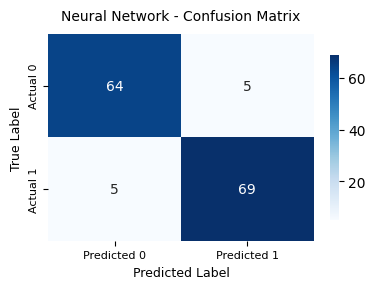

In [501]:
# Train Neural Network
input_shape = (X_train.shape[1],)
nn_model = create_neural_network_model(input_shape)
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

# Predict Neural Network
nn_pred = (nn_model.predict(X_test) > 0.5).astype(int).flatten()
nn_metrics = evaluate_model_performance(y_test, nn_pred, 'Neural Network')
#nn_analysis = comprehensive_model_analysis(nn_model, X_train, X_test, y_train, y_test, 'Neural Network', 'neural_network')


SVM - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        69
           1       0.94      0.84      0.89        74

    accuracy                           0.89       143
   macro avg       0.89      0.89      0.89       143
weighted avg       0.89      0.89      0.89       143


SVM - Performance Metrics Summary:
Accuracy:  0.8881
Precision: 0.9394
Recall:    0.8378
F1 Score:  0.8857


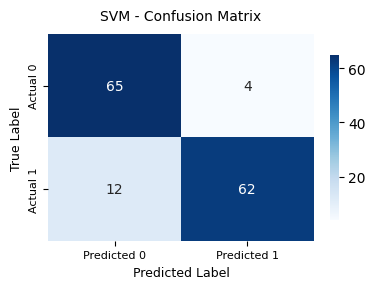

In [502]:
# Train SVM
svm_model = create_and_train_svm_model(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_metrics = evaluate_model_performance(y_test, svm_pred, 'SVM')


Decision Tree - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        69
           1       0.92      0.93      0.93        74

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143


Decision Tree - Performance Metrics Summary:
Accuracy:  0.9231
Precision: 0.9200
Recall:    0.9324
F1 Score:  0.9262


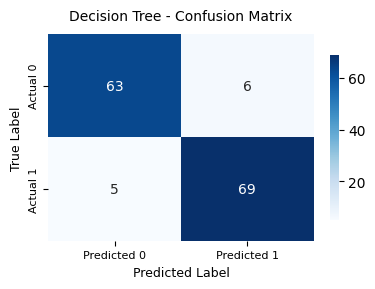

In [503]:
# Train Decision Tree
dt_model = create_and_train_decision_tree(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_metrics = evaluate_model_performance(y_test, dt_pred, 'Decision Tree')

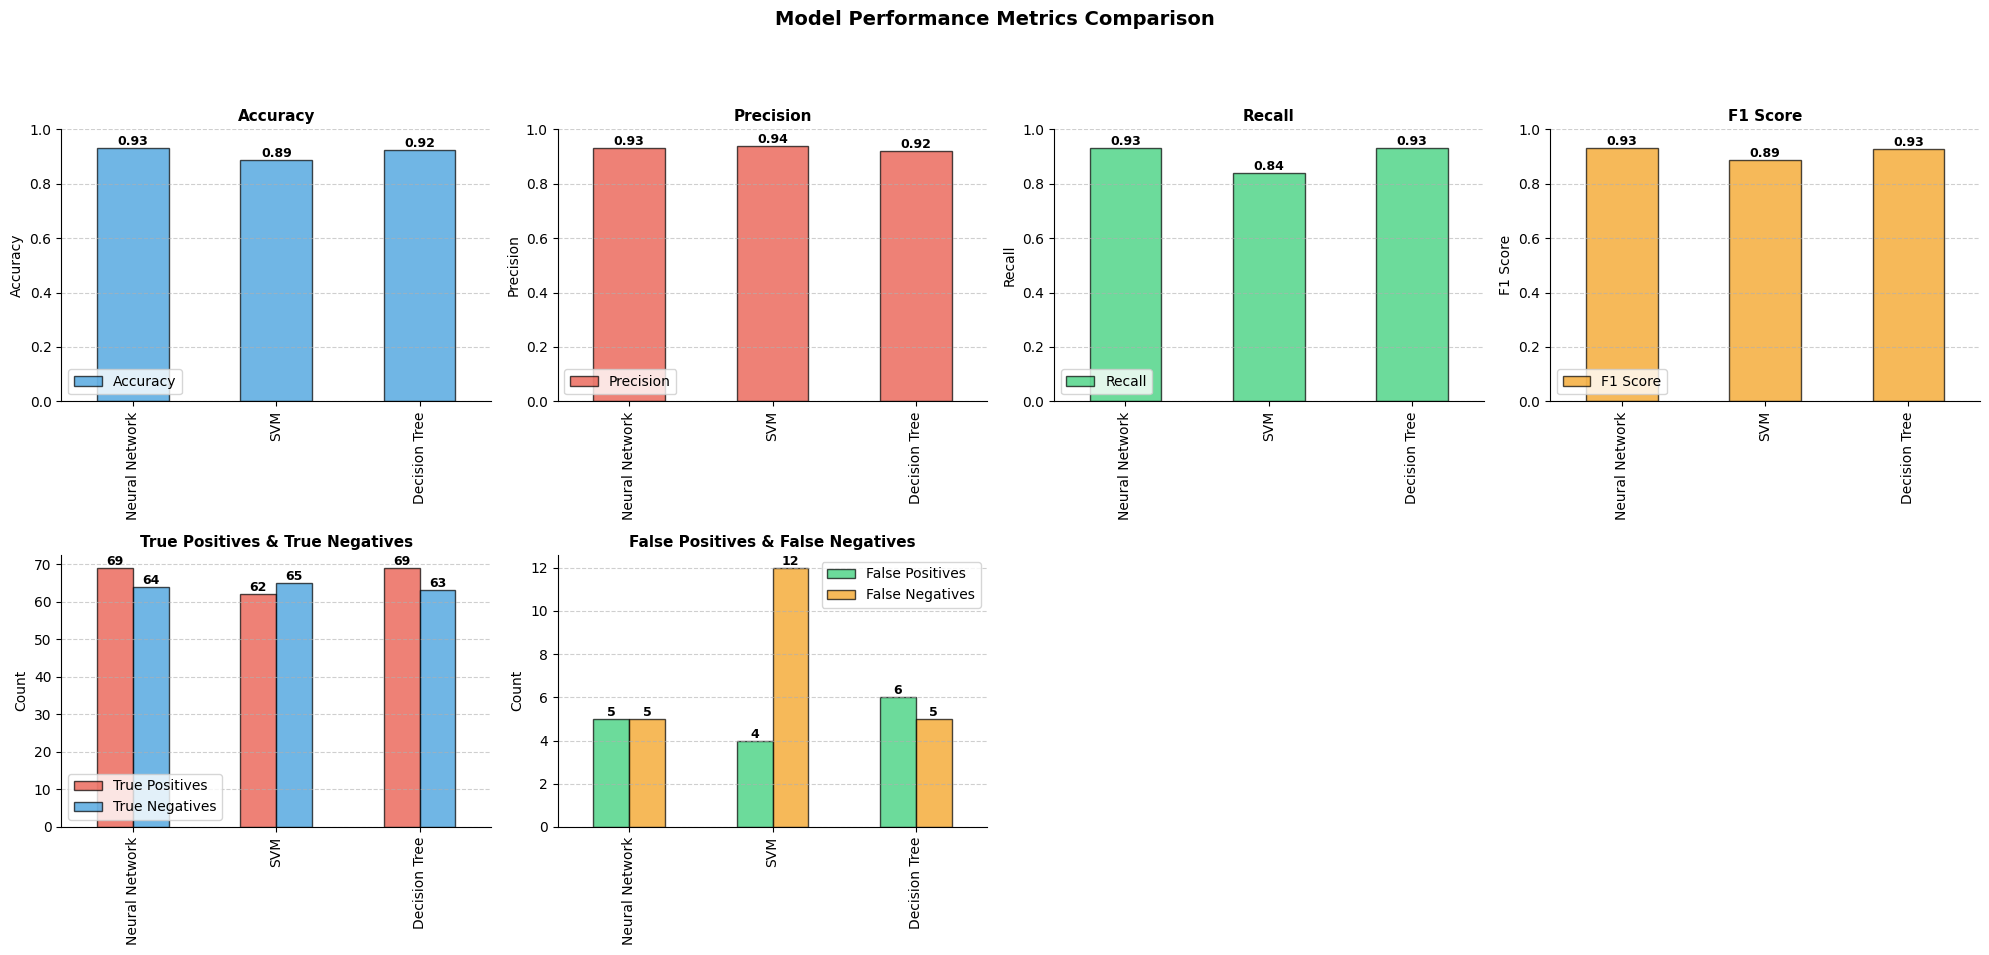

In [504]:
# Visualize Performance Metrics
plot_model_performance_metrics([nn_metrics, svm_metrics, dt_metrics])

# Sporcamento del dataset e analisi degli effetti

Operzioni da svolgere
- valori nulli
- duplicati
- outlier

fare grafici con percentuale di sporcamento, tipologia di sporcamento e tipologia di elemento su cui viene applicato.

ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE

ANALISI CON 10% VALORI MANCANTI
Valori mancanti introdotti: 1641/17130 celle (righe x colonne) (9.6%)

Addestramento Neural Network con 10% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Neural Network (10% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        69
           1       0.96      0.88      0.92        74

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143


Neural Network (10% missing) - Performance Metrics Summary:
Accuracy:  0.9161
Precision: 0.9559
Recall:    0.8784
F1 Score:  0.9155


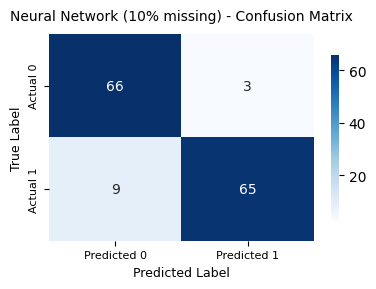


Addestramento SVM con 10% valori mancanti...

SVM (10% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        69
           1       0.95      0.80      0.87        74

    accuracy                           0.87       143
   macro avg       0.88      0.88      0.87       143
weighted avg       0.89      0.87      0.87       143


SVM (10% missing) - Performance Metrics Summary:
Accuracy:  0.8741
Precision: 0.9516
Recall:    0.7973
F1 Score:  0.8676


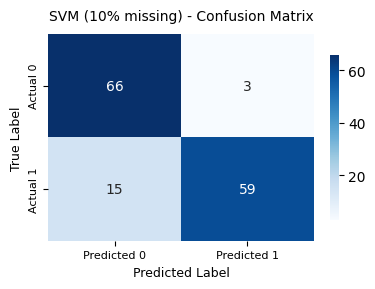


Addestramento Decision Tree con 10% valori mancanti...

Decision Tree (10% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        69
           1       0.96      0.96      0.96        74

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143


Decision Tree (10% missing) - Performance Metrics Summary:
Accuracy:  0.9580
Precision: 0.9595
Recall:    0.9595
F1 Score:  0.9595


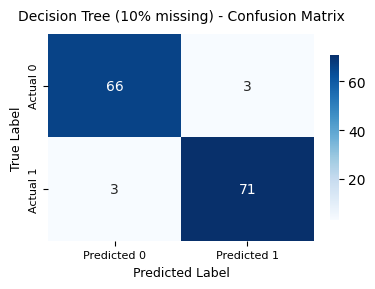


Visualizzazione performance con 10% valori mancanti:


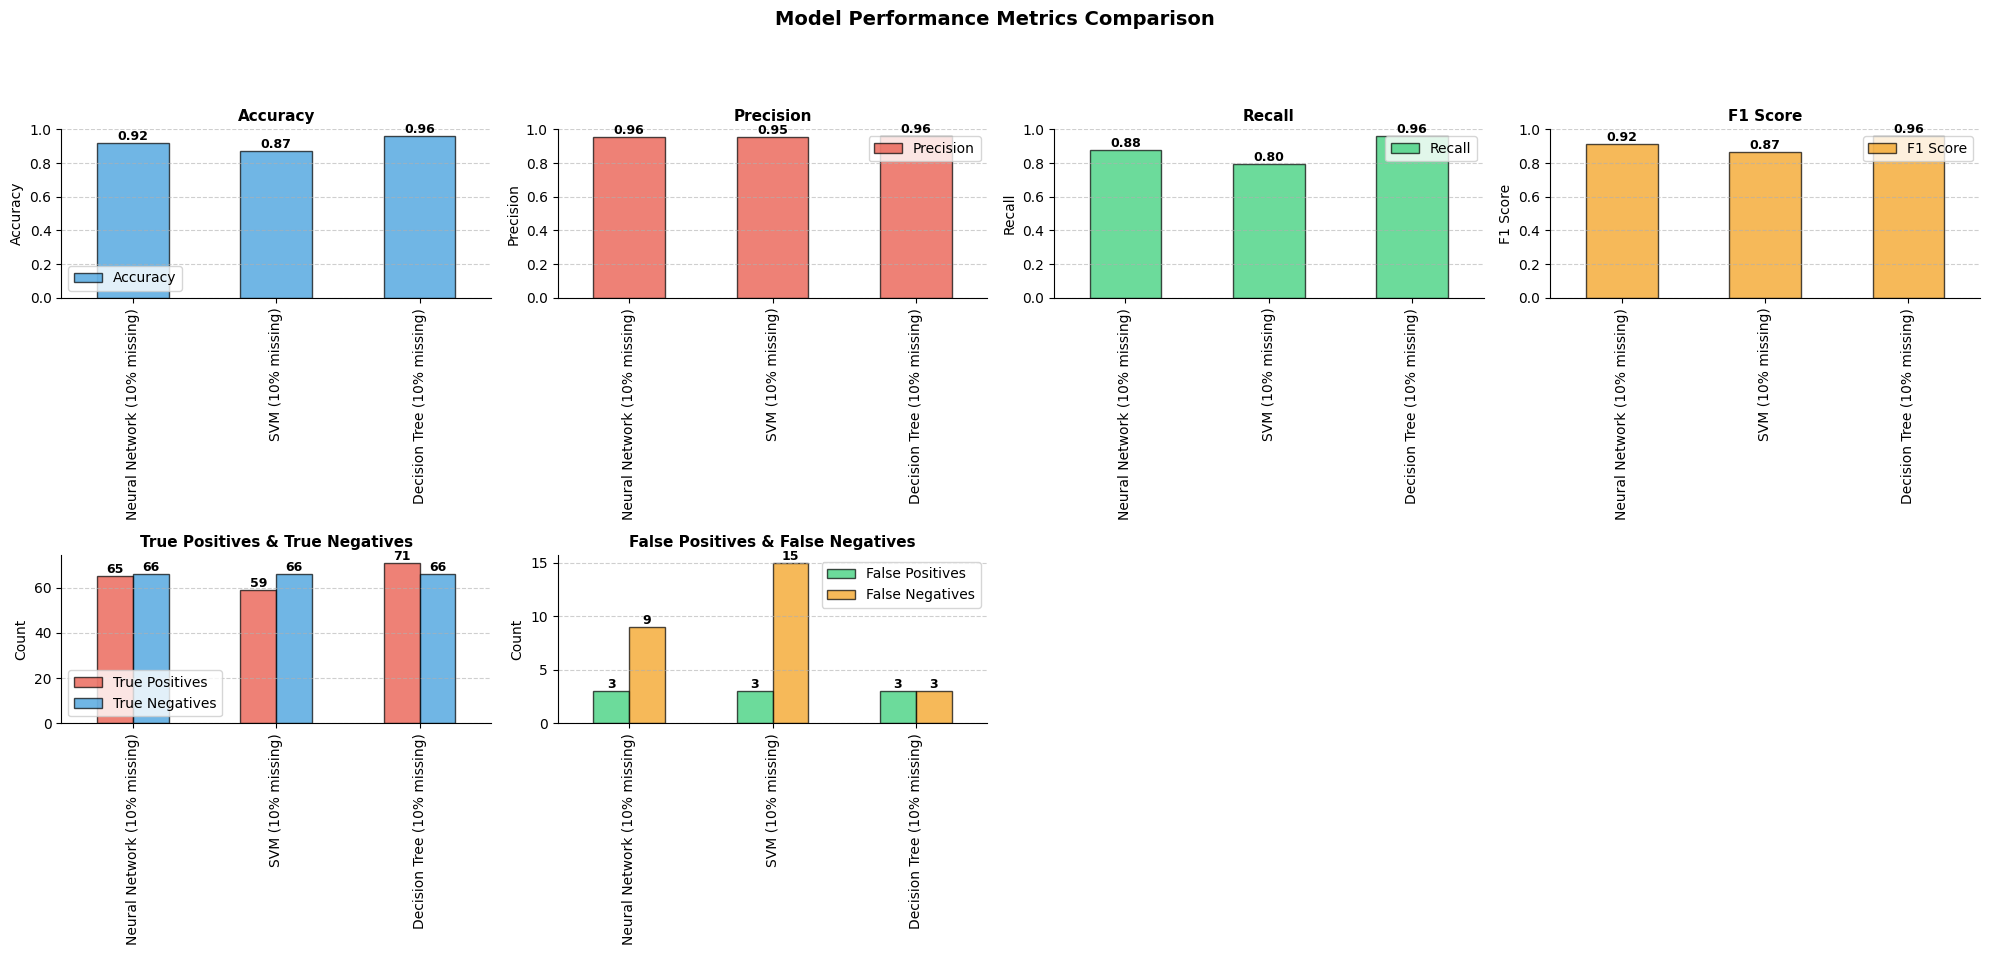


ANALISI CON 20% VALORI MANCANTI
Valori mancanti introdotti: 3106/17130 celle (righe x colonne) (18.1%)

Addestramento Neural Network con 20% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Neural Network (20% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.30        69
           1       0.56      1.00      0.72        74

    accuracy                           0.60       143
   macro avg       0.78      0.59      0.51       143
weighted avg       0.77      0.60      0.52       143


Neural Network (20% missing) - Performance Metrics Summary:
Accuracy:  0.6014
Precision: 0.5649
Recall:    1.0000
F1 Score:  0.7220


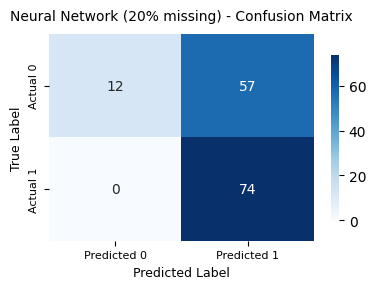


Addestramento SVM con 20% valori mancanti...

SVM (20% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.78      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (20% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9508
Recall:    0.7838
F1 Score:  0.8593


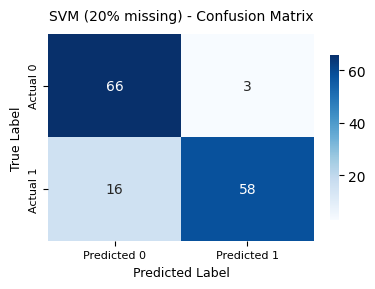


Addestramento Decision Tree con 20% valori mancanti...

Decision Tree (20% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        69
           1       0.96      0.95      0.95        74

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143


Decision Tree (20% missing) - Performance Metrics Summary:
Accuracy:  0.9510
Precision: 0.9589
Recall:    0.9459
F1 Score:  0.9524


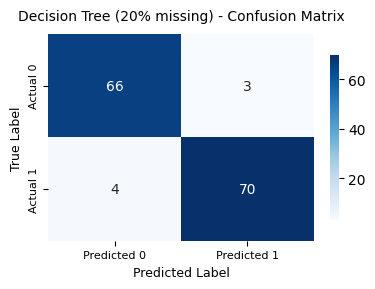


Visualizzazione performance con 20% valori mancanti:


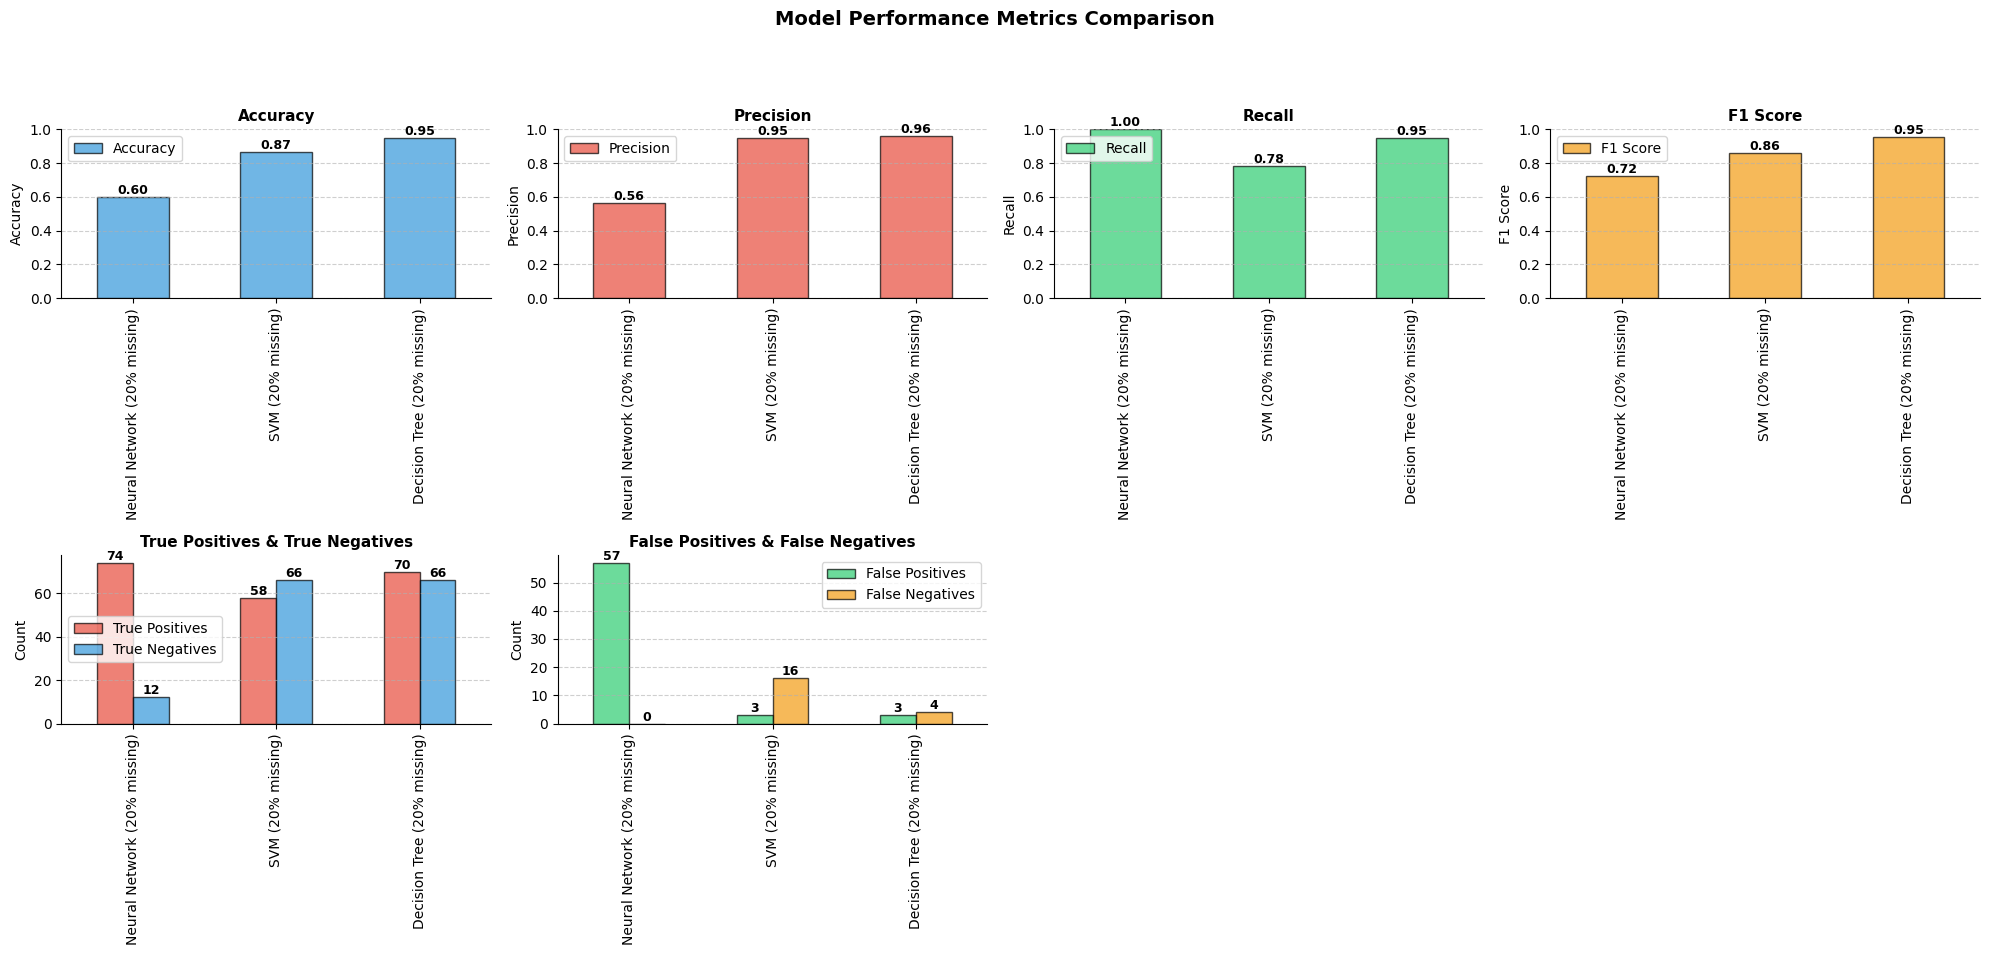


ANALISI CON 30% VALORI MANCANTI
Valori mancanti introdotti: 4420/17130 celle (righe x colonne) (25.8%)

Addestramento Neural Network con 30% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Neural Network (30% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        69
           1       0.83      0.86      0.85        74

    accuracy                           0.84       143
   macro avg       0.84      0.84      0.84       143
weighted avg       0.84      0.84      0.84       143


Neural Network (30% missing) - Performance Metrics Summary:
Accuracy:  0.8392
Precision: 0.8312
Recall:    0.8649
F1 Score:  0.8477


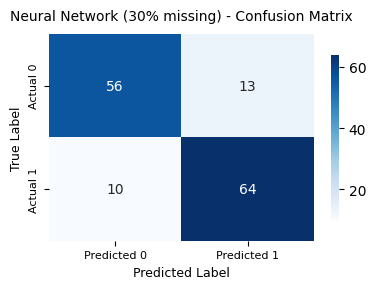


Addestramento SVM con 30% valori mancanti...

SVM (30% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.77      0.85        74

    accuracy                           0.86       143
   macro avg       0.87      0.86      0.86       143
weighted avg       0.88      0.86      0.86       143


SVM (30% missing) - Performance Metrics Summary:
Accuracy:  0.8601
Precision: 0.9500
Recall:    0.7703
F1 Score:  0.8507


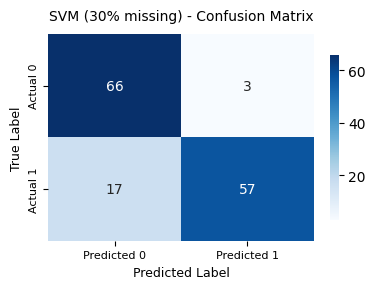


Addestramento Decision Tree con 30% valori mancanti...

Decision Tree (30% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        69
           1       0.94      0.89      0.92        74

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143


Decision Tree (30% missing) - Performance Metrics Summary:
Accuracy:  0.9161
Precision: 0.9429
Recall:    0.8919
F1 Score:  0.9167


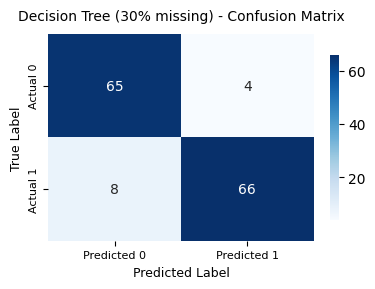


Visualizzazione performance con 30% valori mancanti:


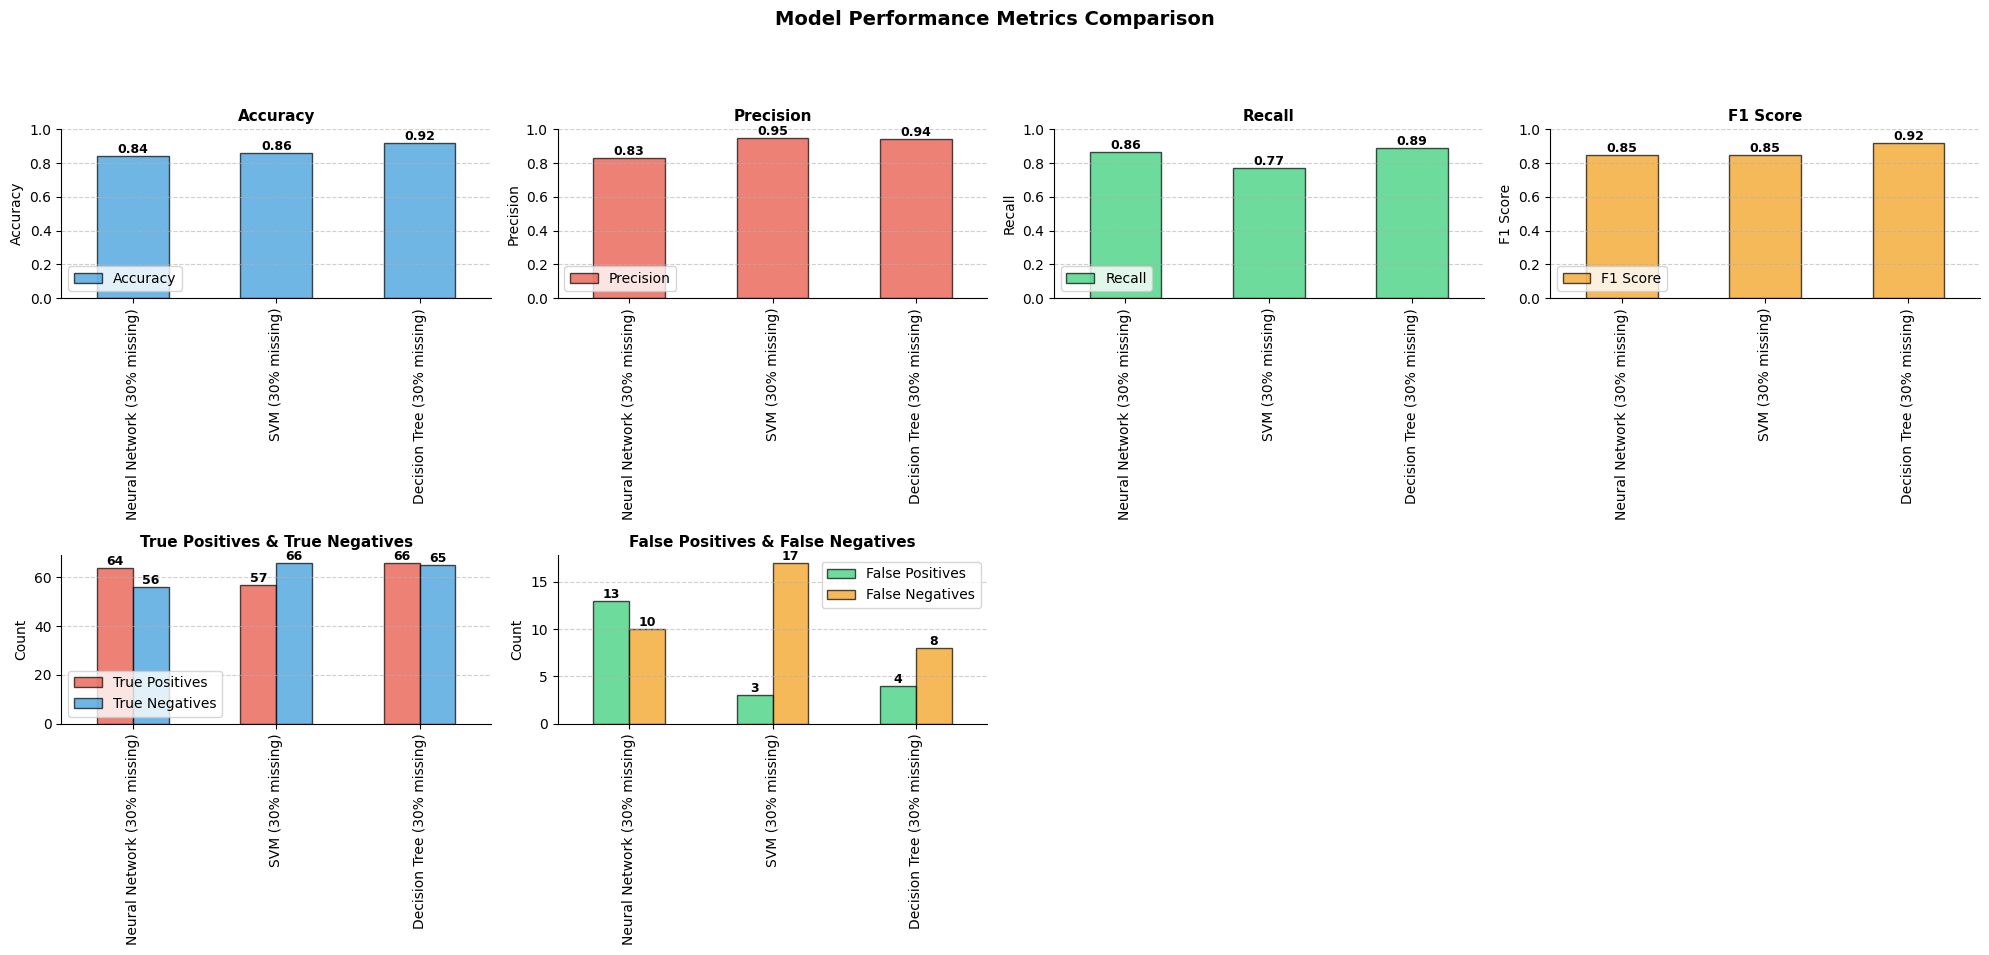


ANALISI CON 40% VALORI MANCANTI
Valori mancanti introdotti: 5699/17130 celle (righe x colonne) (33.3%)

Addestramento Neural Network con 40% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Neural Network (40% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        69
           1       0.97      0.81      0.88        74

    accuracy                           0.89       143
   macro avg       0.90      0.89      0.89       143
weighted avg       0.90      0.89      0.89       143


Neural Network (40% missing) - Performance Metrics Summary:
Accuracy:  0.8881
Precision: 0.9677
Recall:    0.8108
F1 Score:  0.8824


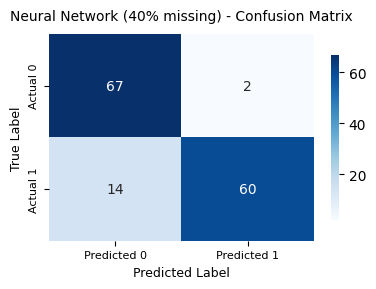


Addestramento SVM con 40% valori mancanti...

SVM (40% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        69
           1       0.97      0.77      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (40% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9661
Recall:    0.7703
F1 Score:  0.8571


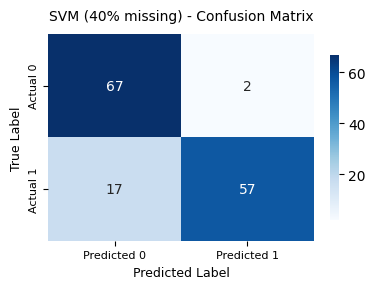


Addestramento Decision Tree con 40% valori mancanti...

Decision Tree (40% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        69
           1       0.90      0.88      0.89        74

    accuracy                           0.89       143
   macro avg       0.89      0.89      0.89       143
weighted avg       0.89      0.89      0.89       143


Decision Tree (40% missing) - Performance Metrics Summary:
Accuracy:  0.8881
Precision: 0.9028
Recall:    0.8784
F1 Score:  0.8904


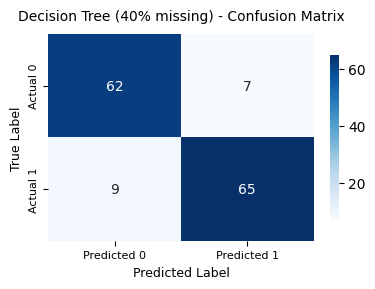


Visualizzazione performance con 40% valori mancanti:


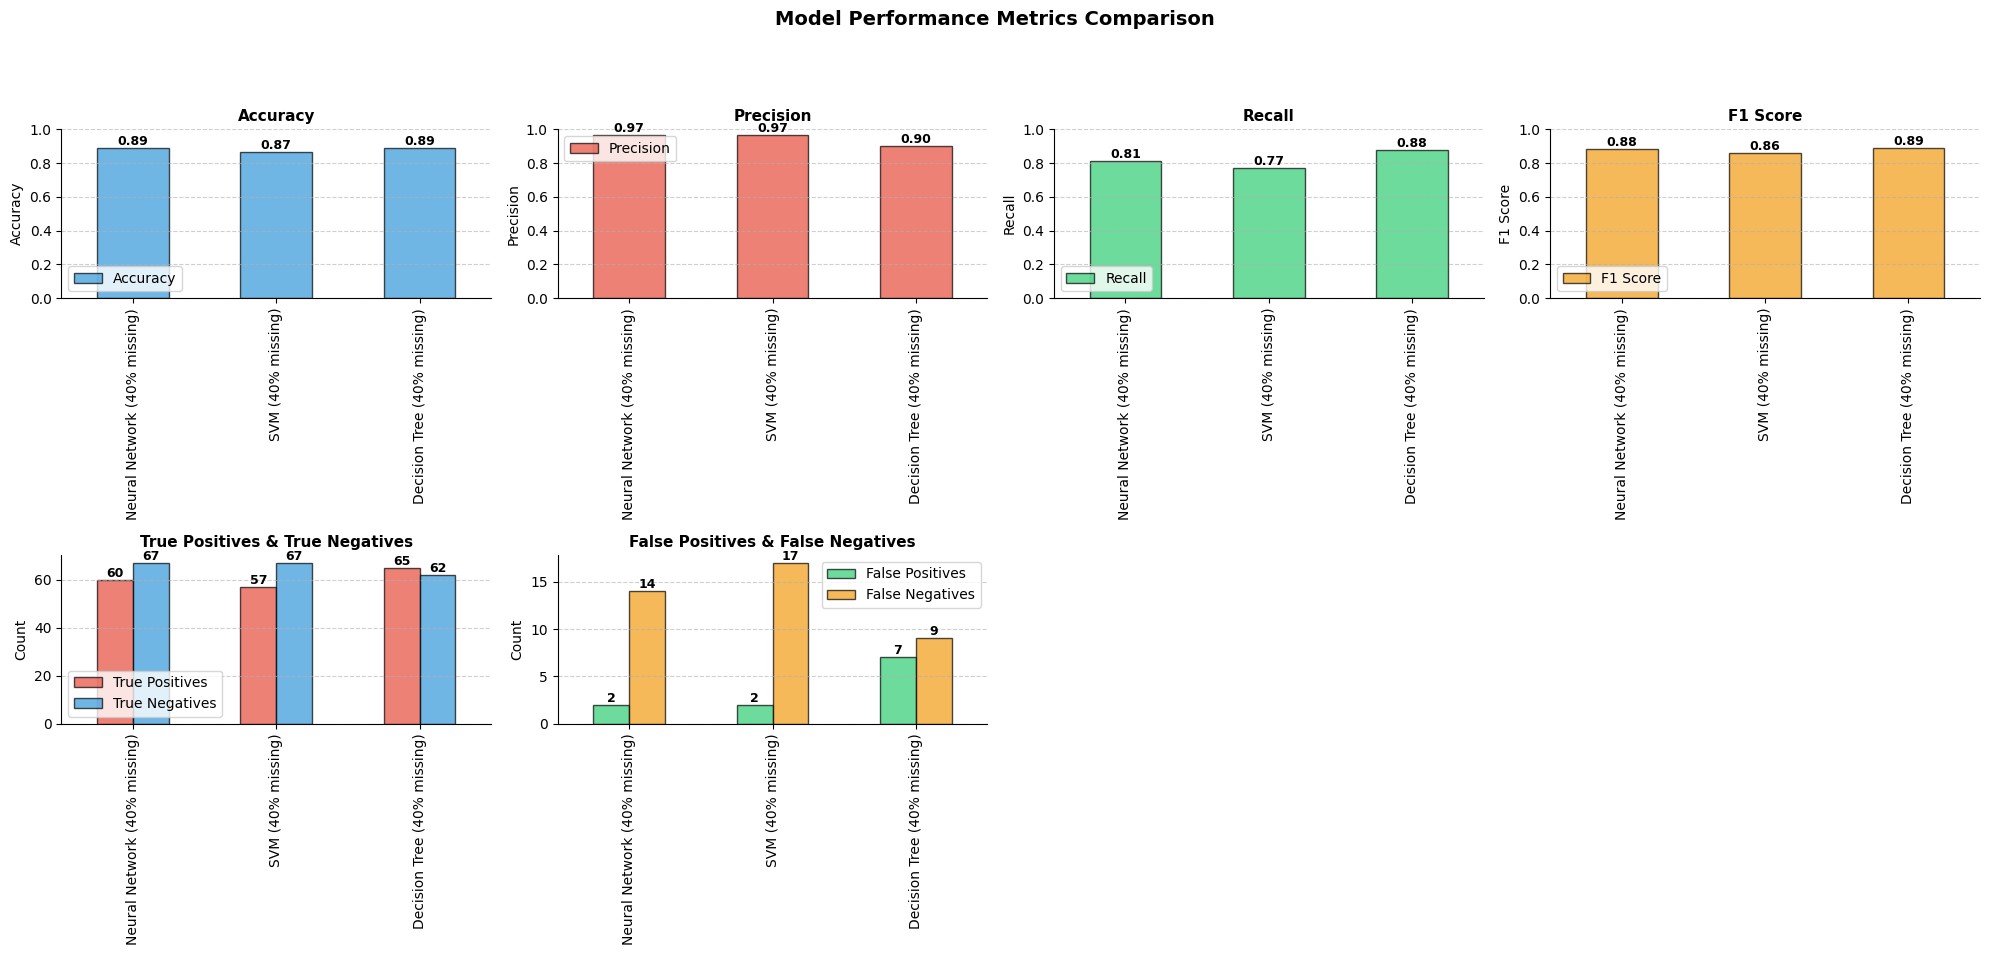


ANALISI CON 50% VALORI MANCANTI
Valori mancanti introdotti: 6728/17130 celle (righe x colonne) (39.3%)

Addestramento Neural Network con 50% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Neural Network (50% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.32      0.47        69
           1       0.61      0.97      0.75        74

    accuracy                           0.66       143
   macro avg       0.76      0.65      0.61       143
weighted avg       0.76      0.66      0.61       143


Neural Network (50% missing) - Performance Metrics Summary:
Accuracy:  0.6573
Precision: 0.6050
Recall:    0.9730
F1 Score:  0.7461


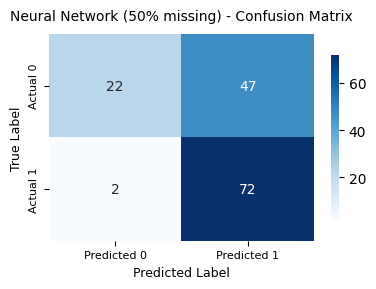


Addestramento SVM con 50% valori mancanti...

SVM (50% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.78      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (50% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9508
Recall:    0.7838
F1 Score:  0.8593


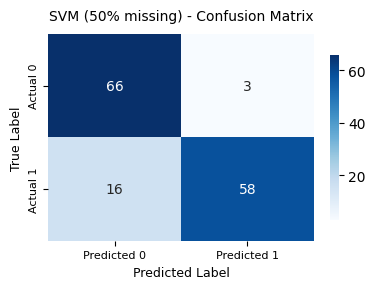


Addestramento Decision Tree con 50% valori mancanti...

Decision Tree (50% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        69
           1       0.85      0.93      0.89        74

    accuracy                           0.88       143
   macro avg       0.89      0.88      0.88       143
weighted avg       0.88      0.88      0.88       143


Decision Tree (50% missing) - Performance Metrics Summary:
Accuracy:  0.8811
Precision: 0.8519
Recall:    0.9324
F1 Score:  0.8903


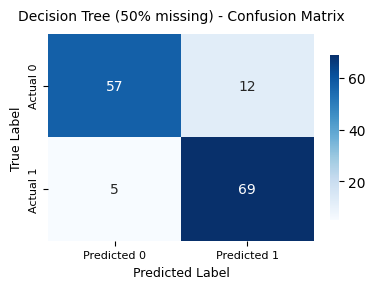


Visualizzazione performance con 50% valori mancanti:


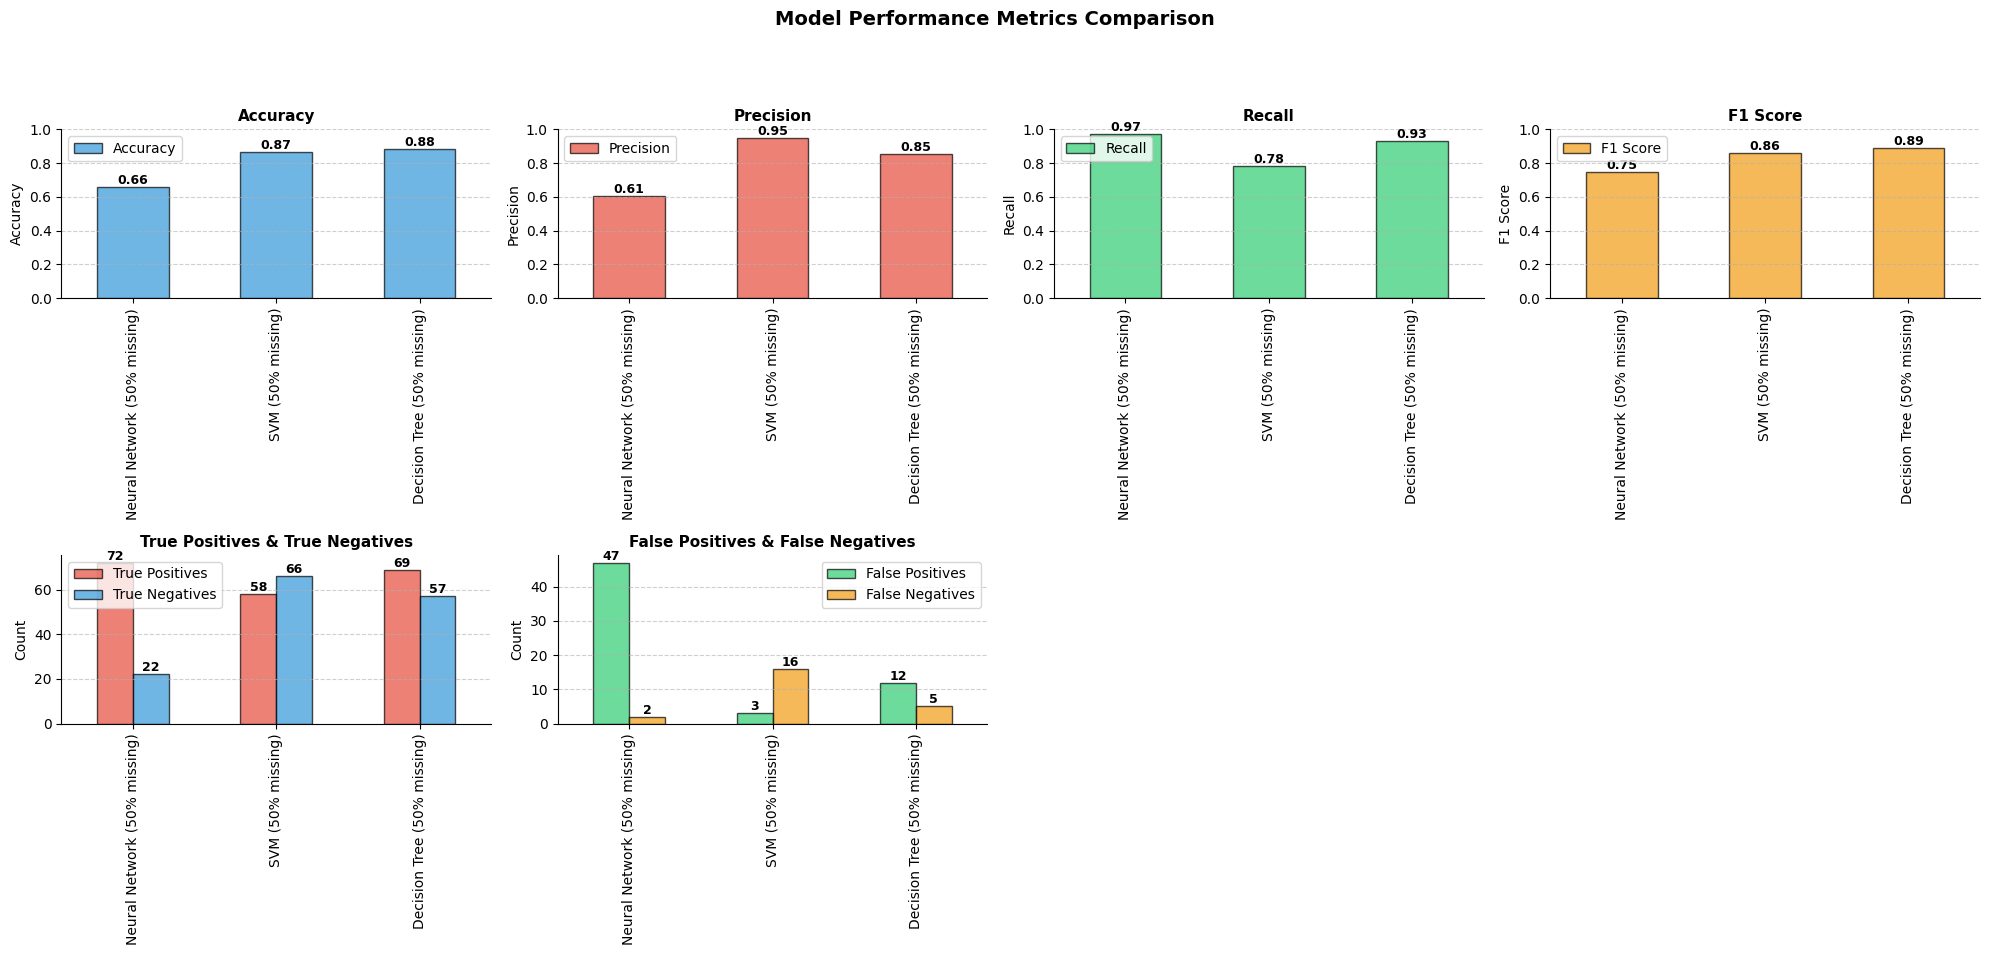


ANALISI CON 60% VALORI MANCANTI
Valori mancanti introdotti: 7732/17130 celle (righe x colonne) (45.1%)

Addestramento Neural Network con 60% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Neural Network (60% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        69
           1       1.00      0.34      0.51        74

    accuracy                           0.66       143
   macro avg       0.79      0.67      0.62       143
weighted avg       0.80      0.66      0.62       143


Neural Network (60% missing) - Performance Metrics Summary:
Accuracy:  0.6573
Precision: 1.0000
Recall:    0.3378
F1 Score:  0.5051


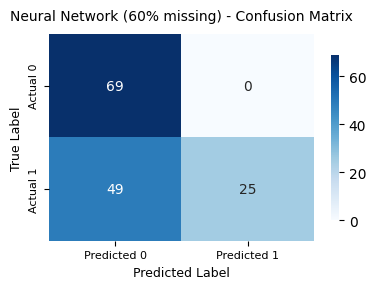


Addestramento SVM con 60% valori mancanti...

SVM (60% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.78      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (60% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9508
Recall:    0.7838
F1 Score:  0.8593


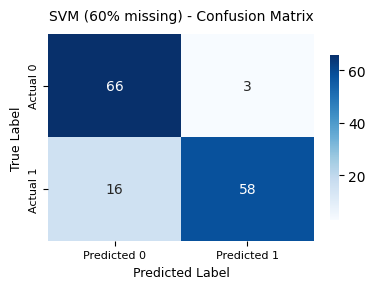


Addestramento Decision Tree con 60% valori mancanti...

Decision Tree (60% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        69
           1       0.91      0.91      0.91        74

    accuracy                           0.90       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143


Decision Tree (60% missing) - Performance Metrics Summary:
Accuracy:  0.9021
Precision: 0.9054
Recall:    0.9054
F1 Score:  0.9054


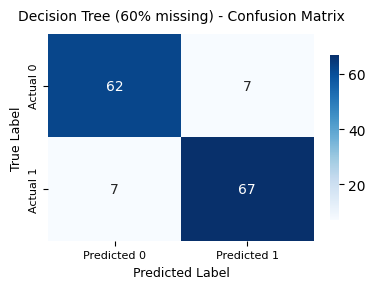


Visualizzazione performance con 60% valori mancanti:


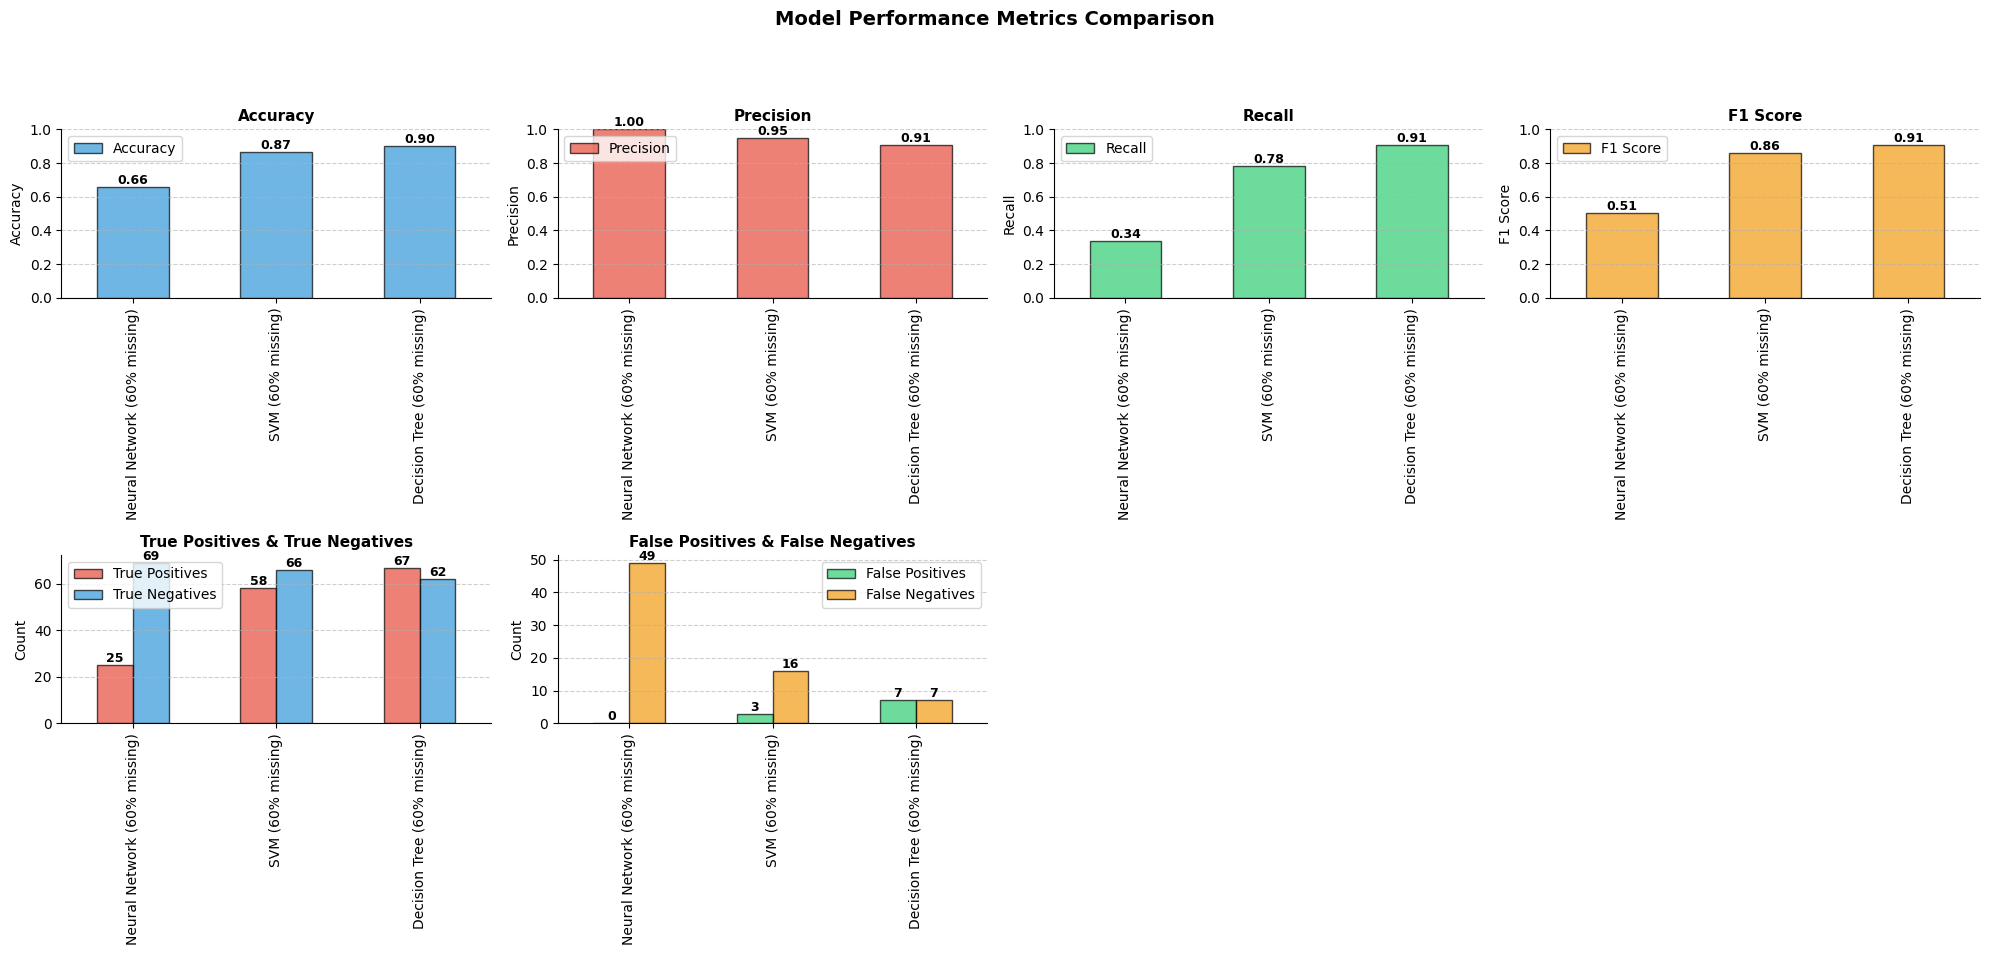


ANALISI CON 70% VALORI MANCANTI
Valori mancanti introdotti: 8668/17130 celle (righe x colonne) (50.6%)

Addestramento Neural Network con 70% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Neural Network (70% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        69
           1       0.88      0.80      0.84        74

    accuracy                           0.84       143
   macro avg       0.84      0.84      0.84       143
weighted avg       0.84      0.84      0.84       143


Neural Network (70% missing) - Performance Metrics Summary:
Accuracy:  0.8392
Precision: 0.8806
Recall:    0.7973
F1 Score:  0.8369


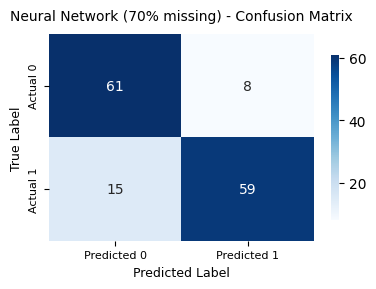


Addestramento SVM con 70% valori mancanti...

SVM (70% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.78      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (70% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9508
Recall:    0.7838
F1 Score:  0.8593


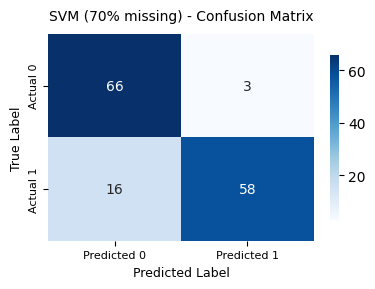


Addestramento Decision Tree con 70% valori mancanti...

Decision Tree (70% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        69
           1       0.89      0.96      0.92        74

    accuracy                           0.92       143
   macro avg       0.92      0.91      0.92       143
weighted avg       0.92      0.92      0.92       143


Decision Tree (70% missing) - Performance Metrics Summary:
Accuracy:  0.9161
Precision: 0.8875
Recall:    0.9595
F1 Score:  0.9221


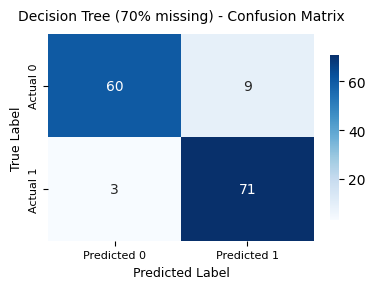


Visualizzazione performance con 70% valori mancanti:


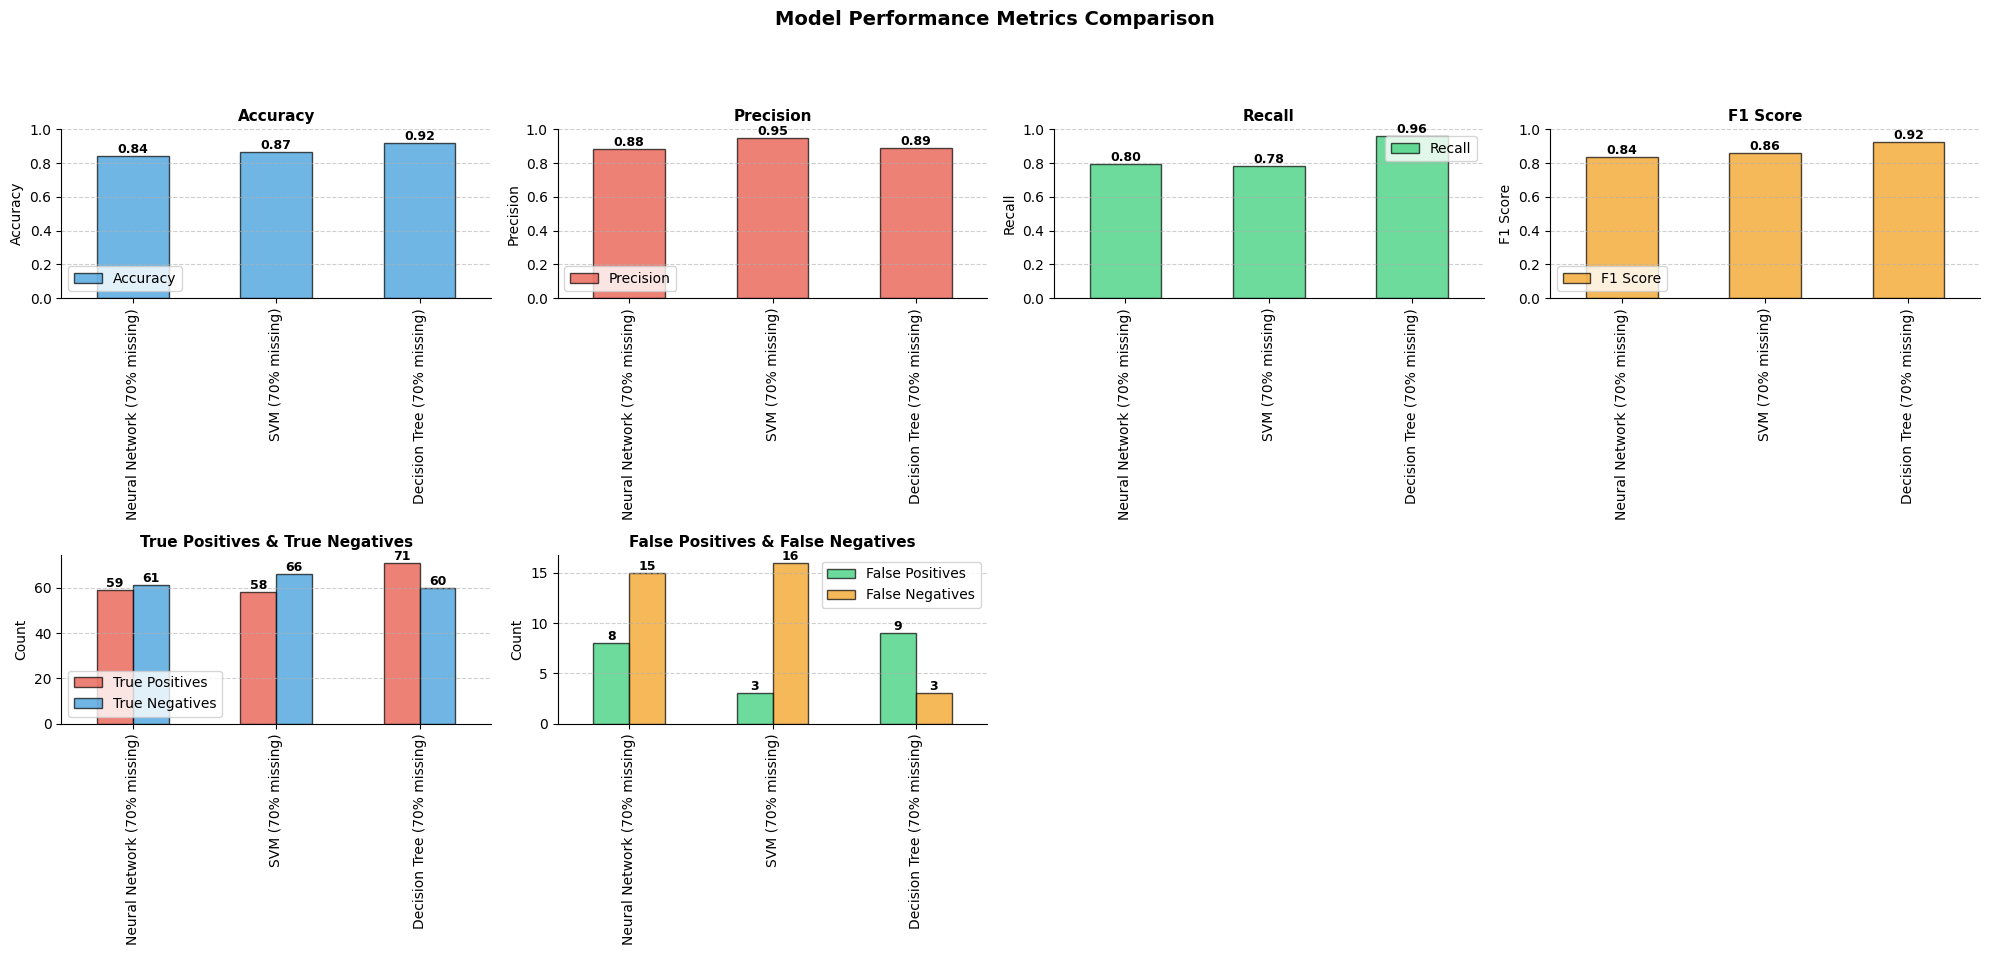


ANALISI CON 80% VALORI MANCANTI
Valori mancanti introdotti: 9477/17130 celle (righe x colonne) (55.3%)

Addestramento Neural Network con 80% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Neural Network (80% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.13      0.23        69
           1       0.55      0.99      0.71        74

    accuracy                           0.57       143
   macro avg       0.72      0.56      0.47       143
weighted avg       0.72      0.57      0.47       143


Neural Network (80% missing) - Performance Metrics Summary:
Accuracy:  0.5734
Precision: 0.5489
Recall:    0.9865
F1 Score:  0.7053


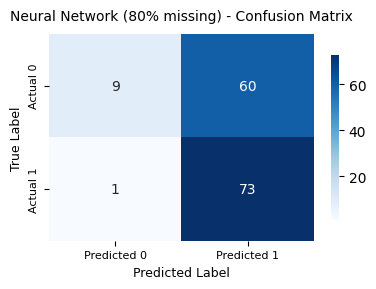


Addestramento SVM con 80% valori mancanti...

SVM (80% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.77      0.85        74

    accuracy                           0.86       143
   macro avg       0.87      0.86      0.86       143
weighted avg       0.88      0.86      0.86       143


SVM (80% missing) - Performance Metrics Summary:
Accuracy:  0.8601
Precision: 0.9500
Recall:    0.7703
F1 Score:  0.8507


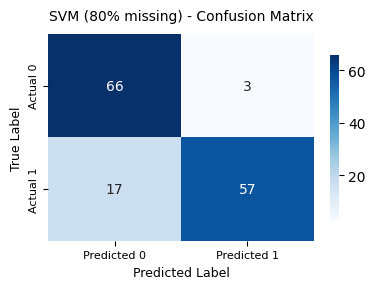


Addestramento Decision Tree con 80% valori mancanti...

Decision Tree (80% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        69
           1       0.87      0.91      0.89        74

    accuracy                           0.88       143
   macro avg       0.88      0.88      0.88       143
weighted avg       0.88      0.88      0.88       143


Decision Tree (80% missing) - Performance Metrics Summary:
Accuracy:  0.8811
Precision: 0.8701
Recall:    0.9054
F1 Score:  0.8874


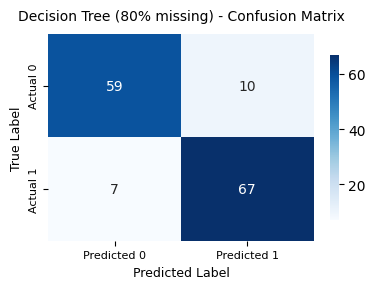


Visualizzazione performance con 80% valori mancanti:


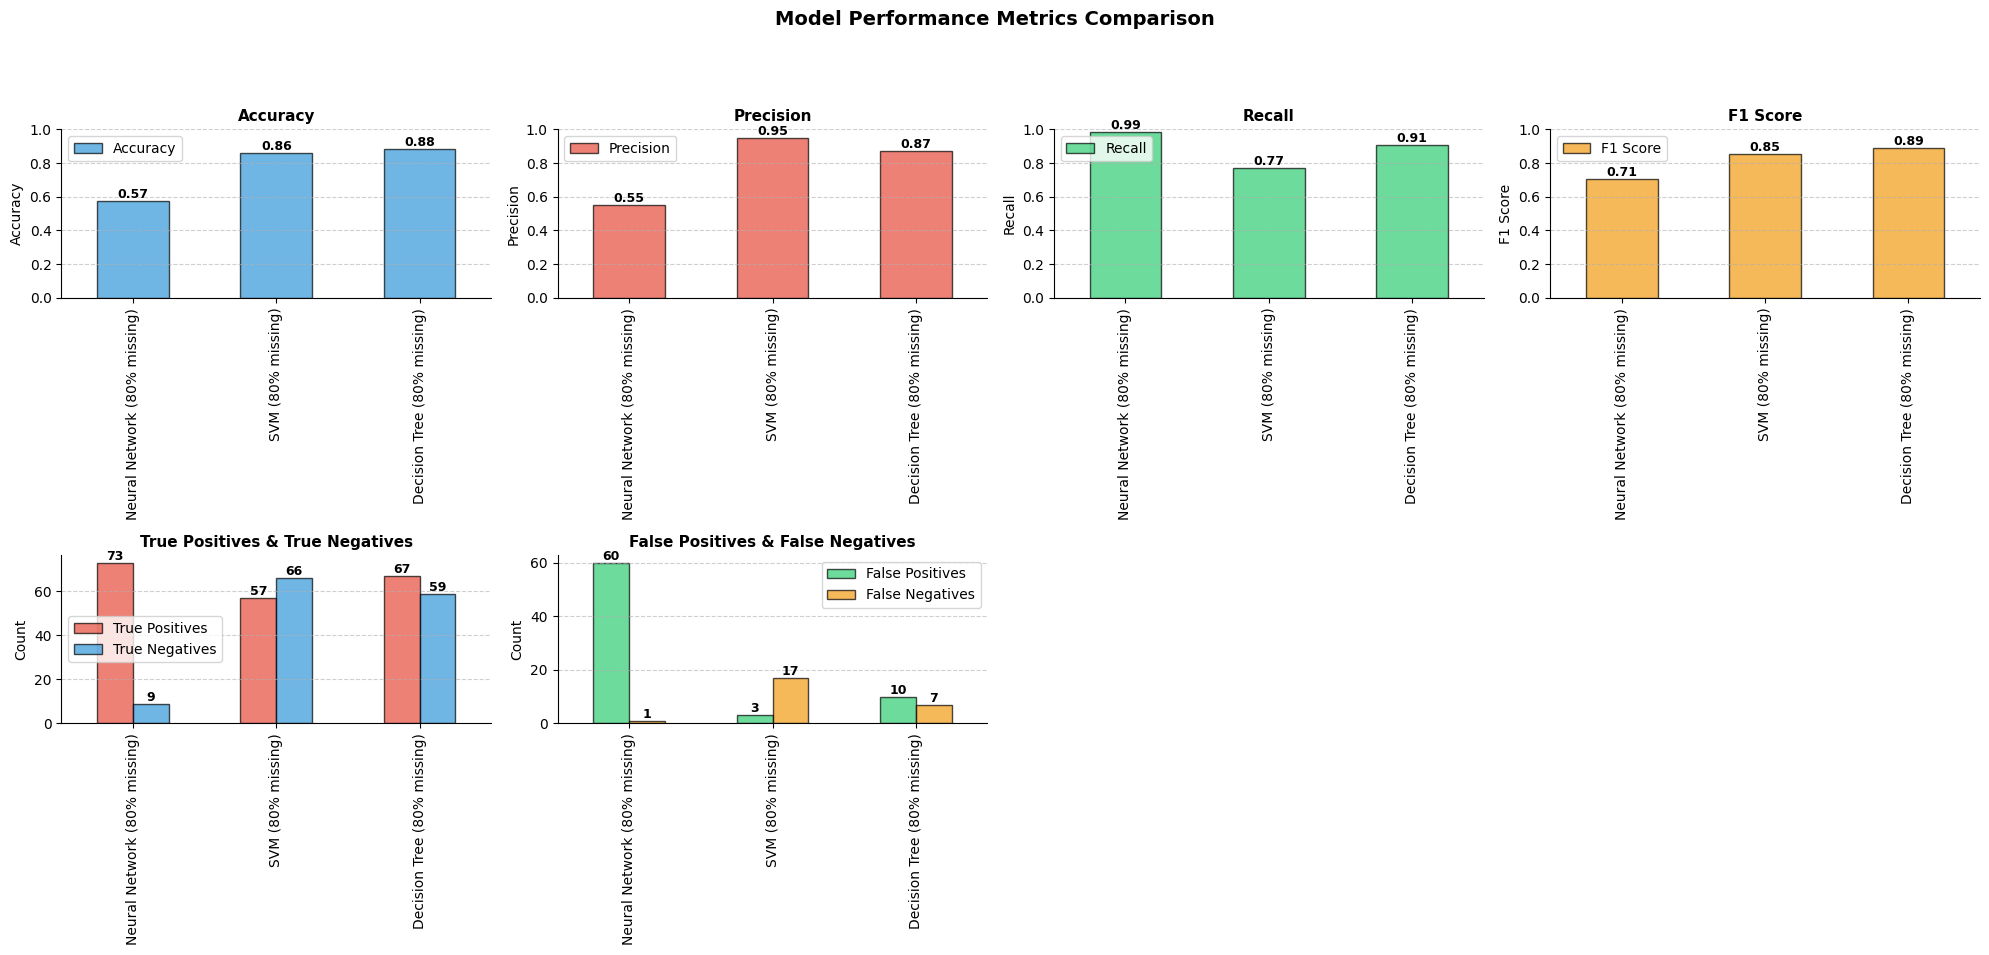


ANALISI CON 90% VALORI MANCANTI
Valori mancanti introdotti: 10123/17130 celle (righe x colonne) (59.1%)

Addestramento Neural Network con 90% valori mancanti...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Neural Network (90% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        69
           1       0.00      0.00      0.00        74

    accuracy                           0.48       143
   macro avg       0.24      0.50      0.33       143
weighted avg       0.23      0.48      0.31       143


Neural Network (90% missing) - Performance Metrics Summary:
Accuracy:  0.4825
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

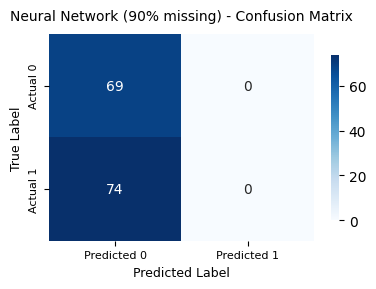


Addestramento SVM con 90% valori mancanti...

SVM (90% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        69
           1       0.95      0.78      0.86        74

    accuracy                           0.87       143
   macro avg       0.88      0.87      0.87       143
weighted avg       0.88      0.87      0.87       143


SVM (90% missing) - Performance Metrics Summary:
Accuracy:  0.8671
Precision: 0.9508
Recall:    0.7838
F1 Score:  0.8593


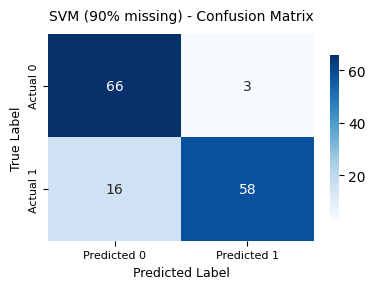


Addestramento Decision Tree con 90% valori mancanti...

Decision Tree (90% missing) - Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81        69
           1       0.77      0.97      0.86        74

    accuracy                           0.84       143
   macro avg       0.87      0.83      0.83       143
weighted avg       0.86      0.84      0.84       143


Decision Tree (90% missing) - Performance Metrics Summary:
Accuracy:  0.8392
Precision: 0.7742
Recall:    0.9730
F1 Score:  0.8623


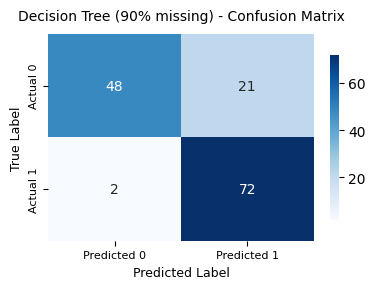


Visualizzazione performance con 90% valori mancanti:


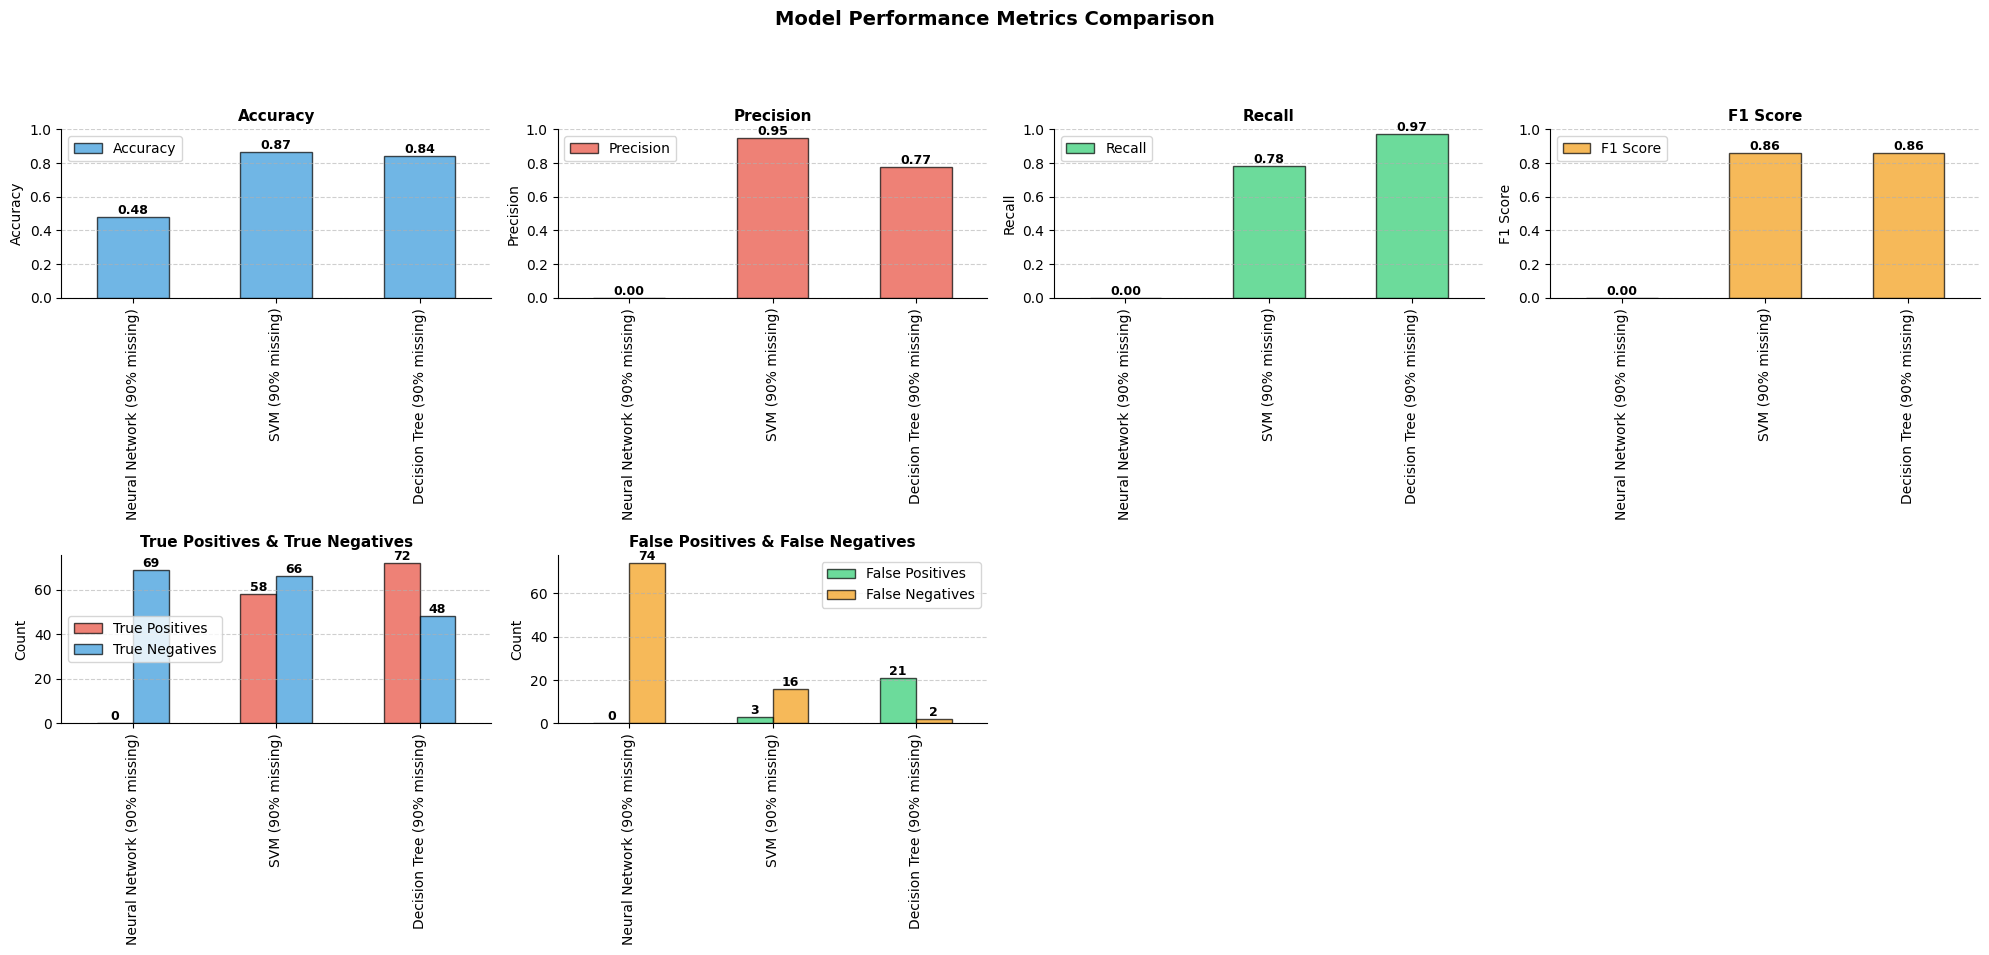

In [505]:
# Sezione Sporcamento del Dataset con Valori Nulli

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
import seaborn as sns

def introduce_missing_data(dataset, percentage):
    """
    Introduce valori nulli in modo casuale nel dataset.

    Parameters:
    - dataset: DataFrame pandas
    - percentage: float, percentuale di valori da rendere nulli (0.0 - 1.0)

    Returns:
    - dataset_with_nulls: DataFrame con valori nulli introdotti
    """
    # Crea una copia del dataset originale
    dataset_with_nulls = dataset.copy()

    # Calcola il numero di celle da rendere mancanti
    num_missing = int(len(dataset_with_nulls) * dataset_with_nulls.shape[1] * percentage)

    # Introduce valori NaN in modo casuale
    for _ in range(num_missing):
        # Seleziona casualmente una riga e una colonna
        row_idx = np.random.randint(0, len(dataset_with_nulls))
        col_idx = np.random.randint(0, dataset_with_nulls.shape[1])

        # Sostituisce il valore con NaN
        dataset_with_nulls.iloc[row_idx, col_idx] = np.nan

    return dataset_with_nulls

def handle_missing_values(X_train, X_test, imputer_type='simple'):
    """
    Gestisce i valori mancanti utilizzando SimpleImputer o KNNImputer.

    Parameters:
    - X_train: Training set
    - X_test: Test set
    - imputer_type: 'simple' o 'knn'

    Returns:
    - X_train_imputed, X_test_imputed: Dataset con valori imputati
    """
    if imputer_type == 'simple':
        # SimpleImputer con media per variabili numeriche
        imputer = SimpleImputer(strategy='mean')
    elif imputer_type == 'knn':
        # KNNImputer
        imputer = KNNImputer(n_neighbors=5)

    # Fit sui dati di training e transform su entrambi
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )

    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    return X_train_imputed, X_test_imputed

def train_and_evaluate_models_with_missing_data(X_train, X_test, y_train, y_test, missing_percentage):
    """
    Addestra e valuta i modelli con dati contenenti valori mancanti.

    Parameters:
    - X_train, X_test: Training e test set
    - y_train, y_test: Target
    - missing_percentage: Percentuale di valori mancanti

    Returns:
    - Lista delle metriche per tutti i modelli
    """
    # Gestisce i valori mancanti con SimpleImputer
    X_train_clean, X_test_clean = handle_missing_values(X_train, X_test, imputer_type='simple')

    # Lista per memorizzare le metriche
    metrics_list = []

    # Neural Network
    print(f"\nAddestramento Neural Network con {missing_percentage:.0%} valori mancanti...")
    input_shape = (X_train_clean.shape[1],)
    nn_model = create_neural_network_model(input_shape)
    history = nn_model.fit(X_train_clean, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    nn_pred = (nn_model.predict(X_test_clean) > 0.5).astype(int).flatten()
    nn_metrics = evaluate_model_performance(y_test, nn_pred, f'Neural Network ({missing_percentage:.0%} missing)')
    metrics_list.append(nn_metrics)

    # SVM
    print(f"\nAddestramento SVM con {missing_percentage:.0%} valori mancanti...")
    svm_model = create_and_train_svm_model(X_train_clean, y_train)
    svm_pred = svm_model.predict(X_test_clean)
    svm_metrics = evaluate_model_performance(y_test, svm_pred, f'SVM ({missing_percentage:.0%} missing)')
    metrics_list.append(svm_metrics)

    # Decision Tree
    print(f"\nAddestramento Decision Tree con {missing_percentage:.0%} valori mancanti...")
    dt_model = create_and_train_decision_tree(X_train_clean, y_train)
    dt_pred = dt_model.predict(X_test_clean)
    dt_metrics = evaluate_model_performance(y_test, dt_pred, f'Decision Tree ({missing_percentage:.0%} missing)')
    metrics_list.append(dt_metrics)

    return metrics_list

# Esecuzione dell'analisi con valori mancanti
print("="*60)
print("ANALISI DELL'IMPATTO DEI VALORI MANCANTI SULLE PERFORMANCE")
print("="*60)

# Definisce le percentuali di sporcamento
missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lista per memorizzare tutti i risultati
all_results = []

# Itera attraverso le diverse percentuali di valori mancanti
for missing_pct in missing_percentages:
    print(f"\n{'='*50}")
    print(f"ANALISI CON {missing_pct:.0%} VALORI MANCANTI")
    print(f"{'='*50}")

    # Introduce valori mancanti solo nel training set
    X_train_missing = introduce_missing_data(X_train, missing_pct)

    # Conta i valori mancanti introdotti
    missing_count = X_train_missing.isnull().sum().sum()
    total_values = X_train_missing.shape[0] * X_train_missing.shape[1]
    actual_missing_pct = missing_count / total_values

    print(f"Valori mancanti introdotti: {missing_count}/{total_values} celle (righe x colonne) ({actual_missing_pct:.1%})")

    # Addestra e valuta i modelli
    results = train_and_evaluate_models_with_missing_data(
        X_train_missing, X_test, y_train, y_test, missing_pct
    )

    # Memorizza i risultati
    all_results.append(results)

    # Visualizza le performance per questa percentuale
    print(f"\nVisualizzazione performance con {missing_pct:.0%} valori mancanti:")
    plot_model_performance_metrics(results)


VISUALIZZAZIONE EVOLUZIONE PERFORMANCE


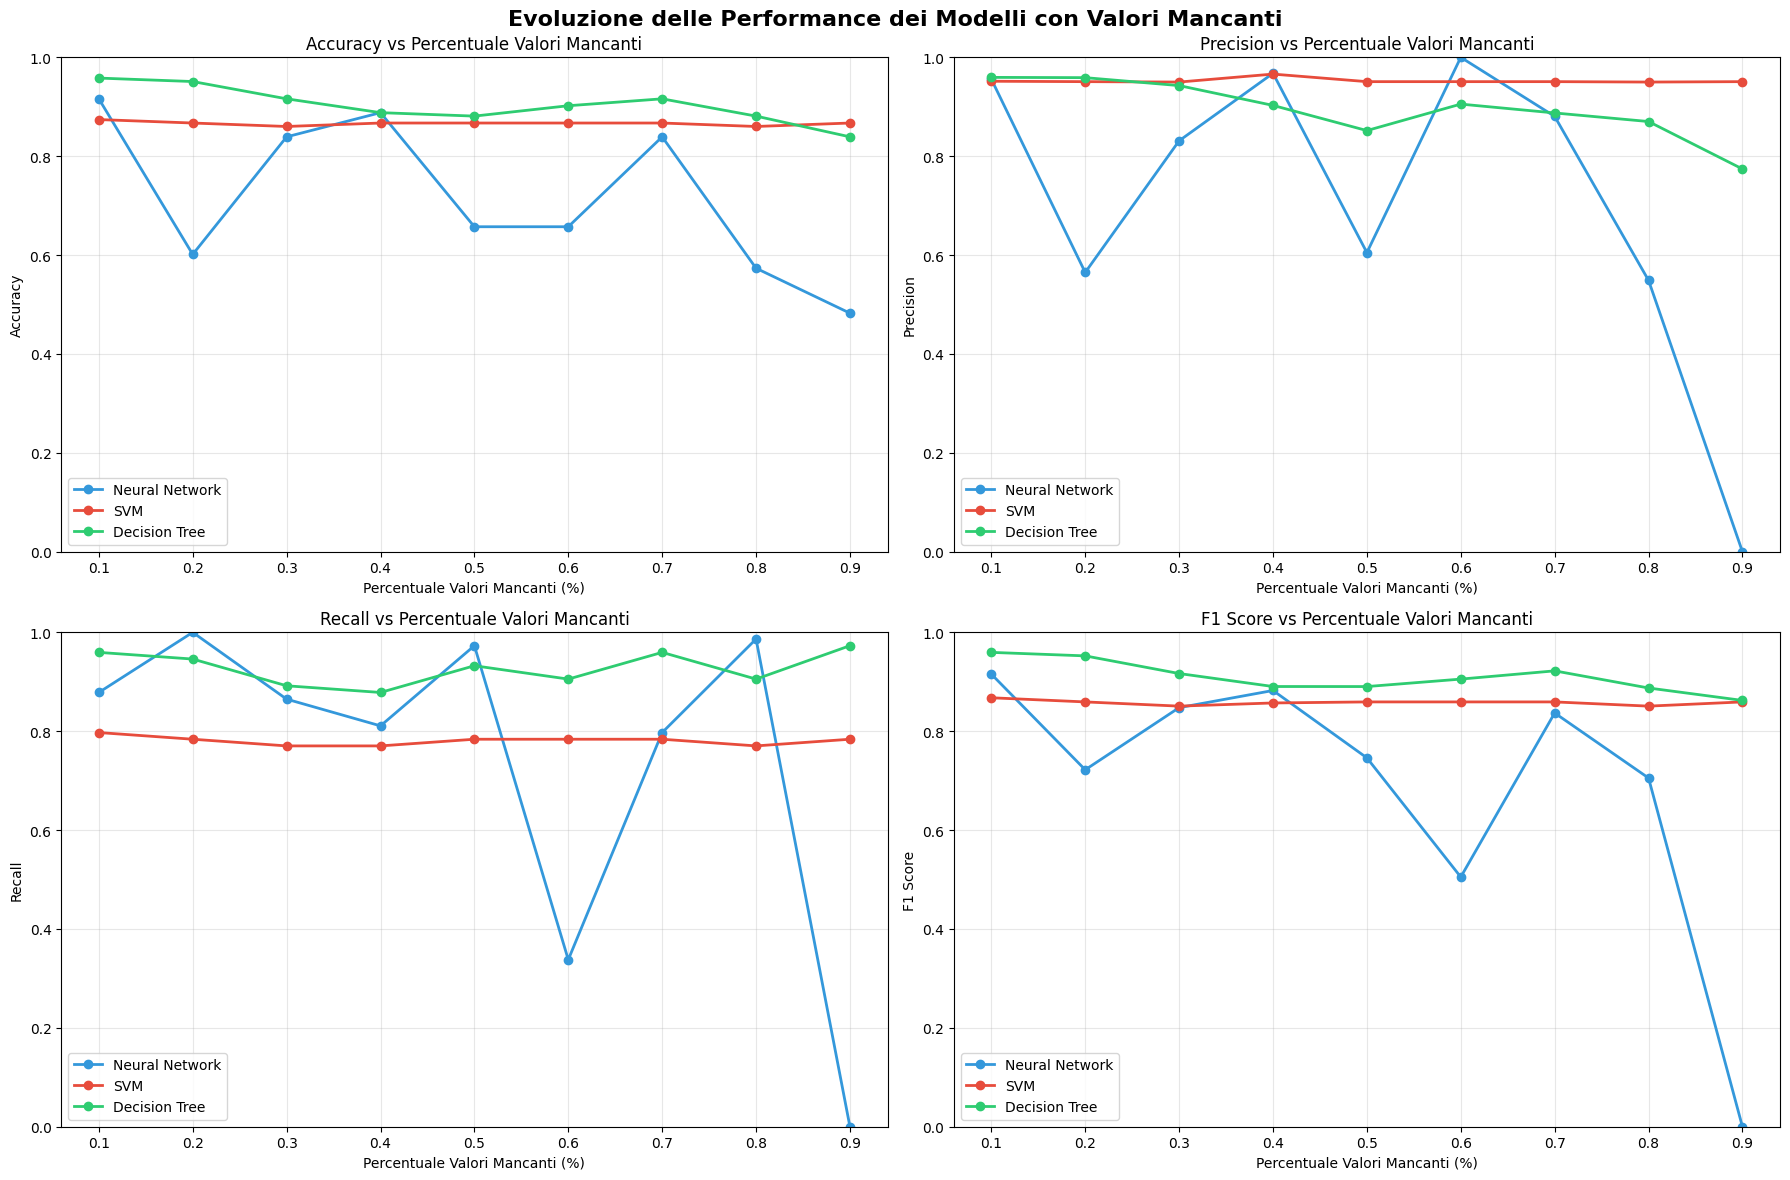

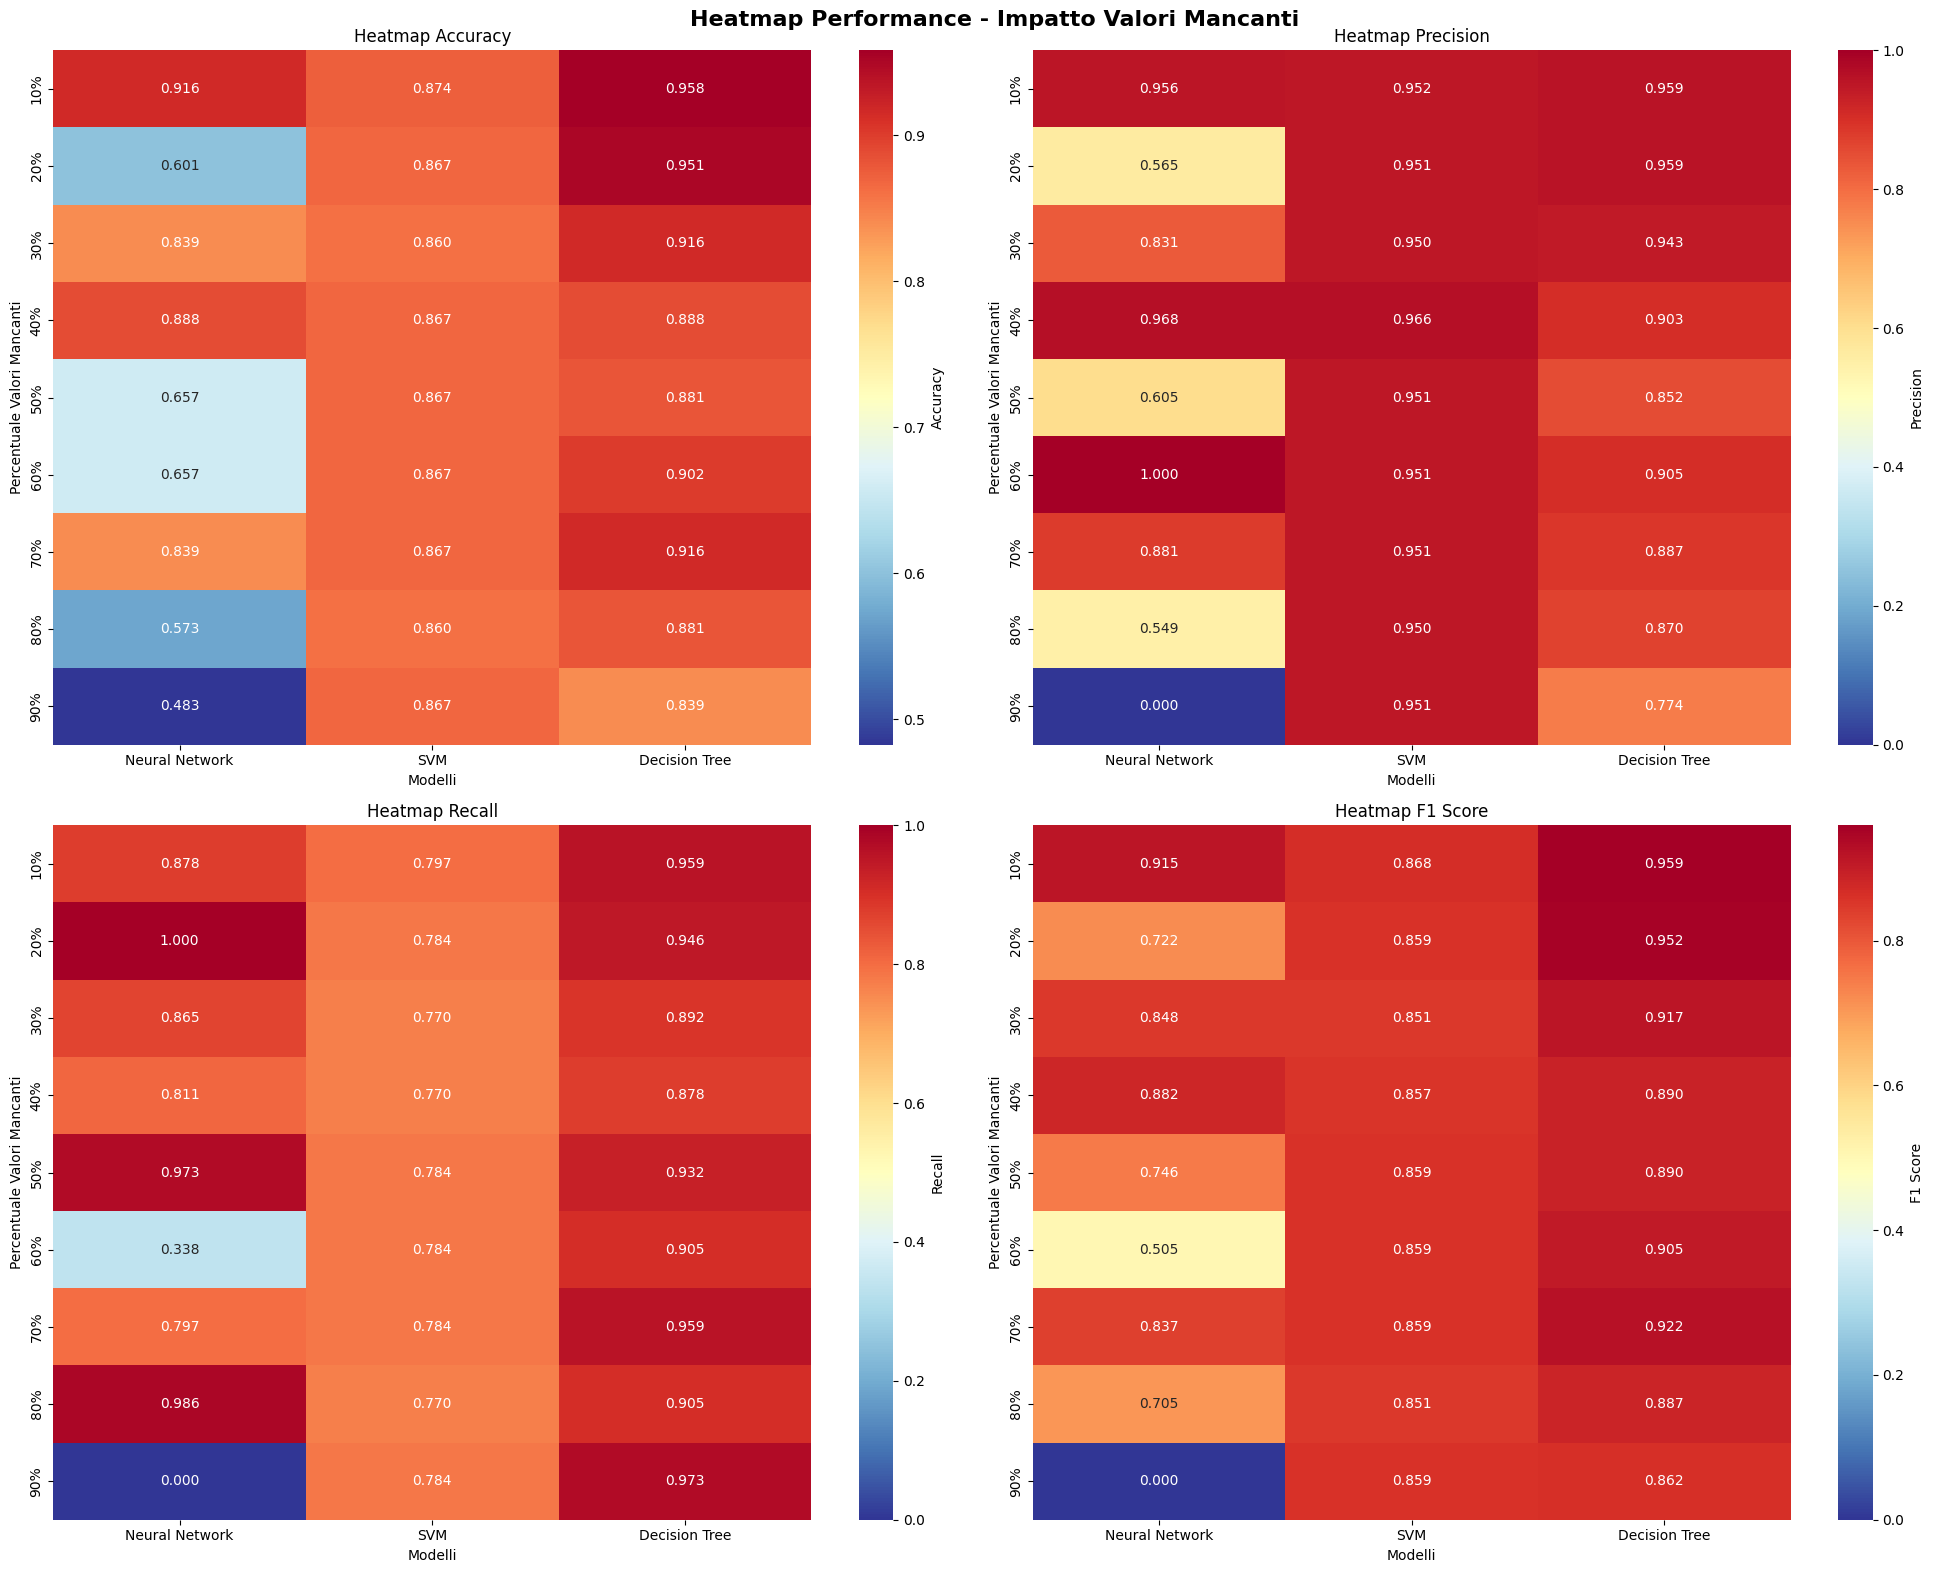


ANALISI STATISTICA FINALE

NEURAL NETWORK:
----------------------------------------
Accuracy    : 0.916 → 0.483 (degrado: 0.434, 47.3%)
Precision   : 0.956 → 0.000 (degrado: 0.956, 100.0%)
Recall      : 0.878 → 0.000 (degrado: 0.878, 100.0%)
F1 Score    : 0.915 → 0.000 (degrado: 0.915, 100.0%)

SVM:
----------------------------------------
Accuracy    : 0.874 → 0.867 (degrado: 0.007, 0.8%)
Precision   : 0.952 → 0.951 (degrado: 0.001, 0.1%)
Recall      : 0.797 → 0.784 (degrado: 0.014, 1.7%)
F1 Score    : 0.868 → 0.859 (degrado: 0.008, 1.0%)

DECISION TREE:
----------------------------------------
Accuracy    : 0.958 → 0.839 (degrado: 0.119, 12.4%)
Precision   : 0.959 → 0.774 (degrado: 0.185, 19.3%)
Recall      : 0.959 → 0.973 (degrado: -0.014, -1.4%)
F1 Score    : 0.959 → 0.862 (degrado: 0.097, 10.1%)

Analisi completata!


In [506]:
def plot_performance_evolution(all_results, missing_percentages):
    """
    Visualizza l'evoluzione delle performance dei modelli al variare della percentuale di valori mancanti.

    Parameters:
    - all_results: Lista di risultati per ogni percentuale
    - missing_percentages: Lista delle percentuali di valori mancanti
    """
    # Organizza i dati per la visualizzazione
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Crea un dizionario per organizzare i dati
    performance_data = {model: {metric: [] for metric in metrics} for model in models}

    # Estrae i dati dai risultati
    for results in all_results:
        for i, result in enumerate(results):
            model = models[i]
            for metric in metrics:
                performance_data[model][metric].append(result[metric])

    # Crea il grafico
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Evoluzione delle Performance dei Modelli con Valori Mancanti', fontsize=16, fontweight='bold')

    colors = ['#3498db', '#e74c3c', '#2ecc71']

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        for j, model in enumerate(models):
            ax.plot(missing_percentages, performance_data[model][metric],
                   marker='o', linewidth=2, markersize=6, label=model, color=colors[j])

        ax.set_xlabel('Percentuale Valori Mancanti (%)')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Percentuale Valori Mancanti')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def create_missing_data_heatmap(all_results, missing_percentages):
    """
    Crea una heatmap per visualizzare le performance dei modelli in layout 2x2.
    """
    models = ['Neural Network', 'SVM', 'Decision Tree']
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Crea una figura con layout 2x2 per le heatmap
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Heatmap Performance - Impatto Valori Mancanti', fontsize=16, fontweight='bold')

    # Crea una matrice per ogni metrica
    for i, metric in enumerate(metrics):
        data_matrix = []
        for results in all_results:
            row = [result[metric] for result in results]
            data_matrix.append(row)

        row = i // 2
        col = i % 2
        ax = axes[row, col]

        sns.heatmap(data_matrix,
                   xticklabels=models,
                   yticklabels=[f'{p:.0%}' for p in missing_percentages],
                   annot=True, fmt='.3f', cmap='RdYlBu_r',
                   cbar_kws={'label': metric},
                   ax=ax)
        ax.set_title(f'Heatmap {metric}')
        ax.set_xlabel('Modelli')
        ax.set_ylabel('Percentuale Valori Mancanti')

    plt.tight_layout()
    plt.show()



# Visualizzazione finale dell'evoluzione delle performance
print("\n" + "="*60)
print("VISUALIZZAZIONE EVOLUZIONE PERFORMANCE")
print("="*60)

# Grafico dell'evoluzione delle performance
plot_performance_evolution(all_results, missing_percentages)

# Heatmap delle performance
create_missing_data_heatmap(all_results, missing_percentages)

# Analisi statistica finale
print("\n" + "="*60)
print("ANALISI STATISTICA FINALE")
print("="*60)

models = ['Neural Network', 'SVM', 'Decision Tree']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for i, model in enumerate(models):
    print(f"\n{model.upper()}:")
    print("-" * 40)

    for metric in metrics:
        values = [results[i][metric] for results in all_results]
        initial_value = values[0]
        final_value = values[-1]
        degradation = initial_value - final_value
        degradation_pct = (degradation / initial_value) * 100

        print(f"{metric:12}: {initial_value:.3f} → {final_value:.3f} "
              f"(degrado: {degradation:.3f}, {degradation_pct:.1f}%)")

print("\nAnalisi completata!")